In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import cython
# import line_profiler
from typing import Tuple
from cython.parallel import prange

In [2]:
%load_ext Cython

In [3]:
from typing import Tuple

import numpy as np
from numba import njit

from CyRK import nbrk_ode

nbrk_ode_py = nbrk_ode.py_func

In [51]:
@njit()
def y_diff(t, y):
    
    dy = np.zeros_like(y)
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    
    return dy

@njit()
def y_diff_extra(t, y):
    
    extra_0 = (1. - 0.01 * y[1])
    extra_1 = (0.02 * y[0] - 1.)
    dy_0 = extra_0 * y[0]
    dy_1 = extra_1 * y[1]
    
    return np.asarray([dy_0, dy_1, extra_0, extra_1], dtype=y.dtype)

@njit()
def y_diff_extra_extra(t, y):
    
    extra_0 = (1. - 0.01 * y[1])
    extra_1 = (0.02 * y[0] - 1.)
    extra_2 = (1. - 0.01 * y[1]) * 10.
    extra_3 = (0.02 * y[0] - 1.) * 10.
    extra_4 = (1. - 0.01 * y[1]) * 20.
    extra_5 = (0.02 * y[0] - 1.) * 20.
    extra_6 = (1. - 0.01 * y[1]) * -30.
    extra_7 = (0.02 * y[0] - 1.) * -30.
    extra_8 = (1. - 0.01 * y[1]) * 32.
    extra_9 = (0.02 * y[0] - 1.) * -32.
    extra_10 = (1. - 0.01 * y[1]) * -32.
    extra_11 = (0.02 * y[0] - 1.) * -12.
    dy_0 = extra_0 * y[0]
    dy_1 = extra_1 * y[1]
    
    return np.asarray([dy_0, dy_1, extra_0, extra_1, extra_2, extra_3,
                       extra_4, extra_5, extra_6, extra_7, extra_8, extra_9,
                       extra_10, extra_11], dtype=y.dtype)

@njit()
def y_diff2(t, y, dy):
    
    dy[0] = (1. - 0.01 * y[1]) * y[0]
    dy[1] = (0.02 * y[0] - 1.) * y[1]
    
    
@njit()
def y_diff2_extra(t, y, output):
    
    extra_0 = (1. - 0.01 * y[1])
    extra_1 = (0.02 * y[0] - 1.)
    output[0] = extra_0 * y[0]
    output[1] = extra_1 * y[1]
    output[2] = extra_0
    output[3] = extra_1
    
@njit()
def y_diff3(t, y, dy):
    
    dy[0] = (1. - 0.01 * np.real(y[1])) * np.real(y[0]) + (0.02 * np.imag(y[0]) - 1.) * np.imag(y[1]) * 1j
    dy[1] = (0.02 * np.real(y[0]) - 1.) * np.real(y[1]) + (1. - 0.01 * np.imag(y[1])) * np.imag(y[0]) * 1j
    
@njit()
def y_diff4(t, y):
    
    dy = np.zeros_like(y)
    dy[0] = (1. - 0.01 * np.real(y[1])) * np.real(y[0]) + (0.02 * np.imag(y[0]) - 1.) * np.imag(y[1]) * 1j
    dy[1] = (0.02 * np.real(y[0]) - 1.) * np.real(y[1]) + (1. - 0.01 * np.imag(y[1])) * np.imag(y[0]) * 1j
    return dy

initial_conds = np.asarray((20., 20.), dtype=np.complex128)
initial_conds_float = np.asarray((20., 20.), dtype=np.float64)
initial_conds_complex = np.asarray((20. + 0.1j, 20. + 0.1j), dtype=np.complex128)
time_span = (0., 50.)
rtol = 1.0e-7
atol = 1.0e-8

def diff_plot(t, y, is_complex: bool = False):
    
    fig, ax = plt.subplots()
    if is_complex:
        ax.plot(t, np.real(y[0]), 'r', label='$y_{0}$ Re')
        ax.plot(t, np.real(y[1]), 'b', label='$y_{1}$ Re')
        ax.plot(t, np.imag(y[0]), 'r:', label='$y_{0}$ Im')
        ax.plot(t, np.imag(y[1]), 'b:', label='$y_{1}$ Im')
    else:
        ax.plot(t, y[0], 'r', label='$y_{0}$')
        ax.plot(t, y[1], 'b', label='$y_{1}$')
    ax.set(xlabel='$t$', ylabel='$y$')
    ax.legend(loc='best')
    
    plt.show()

In [6]:
%%cython --annotate --force
# distutils: language = c++
import cython
import numpy as np
cimport numpy as np
from numpy.core.multiarray import (interp as compiled_interp, interp_complex as compiled_interp_complex
    )
np.import_array()
from cpython cimport array
from libcpp.string cimport string as string_cpp_t
from libcpp.vector cimport vector as vector_cpp_t
from libcpp cimport bool as bool_cpp_t

np.import_array()

from libc.math cimport sqrt, fabs


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double cabs(double complex value) nogil:
    cdef double v_real = value.real
    cdef double v_imag = value.imag
    return sqrt(v_real * v_real + v_imag * v_imag)


# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9

cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf

cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.


unused_t_eval = np.empty((0,), dtype=np.float64)

# RK23 Constants
cdef double RK23_C[3]
cdef double complex RK23_B[3]
cdef double complex RK23_E[4]
cdef double complex RK23_A[3][3]
cdef unsigned int RK23_order = 3
cdef unsigned int RK23_error_order = 2
cdef unsigned int RK23_n_stages = 3
RK23_C[:] = [0, 1 / 2, 3 / 4]
cdef unsigned int RK23_LEN_C = 3
RK23_B[:] = [2 / 9, 1 / 3, 4 / 9]
RK23_E[:] = [5 / 72, -1 / 12, -1 / 9, 1 / 8]

RK23_A[0][:] = [0, 0, 0]
RK23_A[1][:] = [1 / 2, 0, 0]
RK23_A[2][:] = [0, 3 / 4, 0]

# RK45 Constants
cdef double RK45_C[6]
cdef double complex RK45_B[6]
cdef double complex RK45_E[7]
cdef double complex RK45_A[6][5]
cdef unsigned int RK45_order = 5
cdef unsigned int RK45_error_order = 4
cdef unsigned int RK45_n_stages = 6
RK45_C[:] = [0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1]
cdef unsigned int RK45_LEN_C = 6
RK45_B[:] = [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84]
RK45_E[:] = [-71 / 57600, 0, 71 / 16695, -71 / 1920, 17253 / 339200, -22 / 525, 1 / 40]

RK45_A[0][:] = [0, 0, 0, 0, 0]
RK45_A[1][:] = [1 / 5, 0, 0, 0, 0]
RK45_A[2][:] = [3 / 40, 9 / 40, 0, 0, 0]
RK45_A[3][:] = [44 / 45, -56 / 15, 32 / 9, 0, 0]
RK45_A[4][:] = [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0]
RK45_A[5][:] = [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656]

# DOP863 Constants

cdef int j_, i_
cdef unsigned int DOP_order = 8
cdef unsigned int DOP_error_order = 7
cdef unsigned int DOP_n_stages = 12
cdef unsigned int DOP_n_stages_extended = 16
cdef double DOP_C[16]
DOP_C = [
    0.0,
    0.526001519587677318785587544488e-01,
    0.789002279381515978178381316732e-01,
    0.118350341907227396726757197510,
    0.281649658092772603273242802490,
    0.333333333333333333333333333333,
    0.25,
    0.307692307692307692307692307692,
    0.651282051282051282051282051282,
    0.6,
    0.857142857142857142857142857142,
    1.0,
    1.0,
    0.1,
    0.2,
    0.777777777777777777777777777778]

cdef double DOP_C_REDUCED[12]
for i_ in range(12):
    DOP_C_REDUCED[i_] = DOP_C[i_]
cdef unsigned int DOP_LEN_C = 12

cdef double complex DOP_A[16][16]
for j_ in range(16):
    for i_ in range(16):
        DOP_A[i_][j_] = 0.

DOP_A[1][0] = 5.26001519587677318785587544488e-2

DOP_A[2][0] = 1.97250569845378994544595329183e-2
DOP_A[2][1] = 5.91751709536136983633785987549e-2

DOP_A[3][0] = 2.95875854768068491816892993775e-2
DOP_A[3][2] = 8.87627564304205475450678981324e-2

DOP_A[4][0] = 2.41365134159266685502369798665e-1
DOP_A[4][2] = -8.84549479328286085344864962717e-1
DOP_A[4][3] = 9.24834003261792003115737966543e-1

DOP_A[5][0] = 3.7037037037037037037037037037e-2
DOP_A[5][3] = 1.70828608729473871279604482173e-1
DOP_A[5][4] = 1.25467687566822425016691814123e-1

DOP_A[6][0] = 3.7109375e-2
DOP_A[6][3] = 1.70252211019544039314978060272e-1
DOP_A[6][4] = 6.02165389804559606850219397283e-2
DOP_A[6][5] = -1.7578125e-2

DOP_A[7][0] = 3.70920001185047927108779319836e-2
DOP_A[7][3] = 1.70383925712239993810214054705e-1
DOP_A[7][4] = 1.07262030446373284651809199168e-1
DOP_A[7][5] = -1.53194377486244017527936158236e-2
DOP_A[7][6] = 8.27378916381402288758473766002e-3

DOP_A[8][0] = 6.24110958716075717114429577812e-1
DOP_A[8][3] = -3.36089262944694129406857109825
DOP_A[8][4] = -8.68219346841726006818189891453e-1
DOP_A[8][5] = 2.75920996994467083049415600797e1
DOP_A[8][6] = 2.01540675504778934086186788979e1
DOP_A[8][7] = -4.34898841810699588477366255144e1

DOP_A[9][0] = 4.77662536438264365890433908527e-1
DOP_A[9][3] = -2.48811461997166764192642586468
DOP_A[9][4] = -5.90290826836842996371446475743e-1
DOP_A[9][5] = 2.12300514481811942347288949897e1
DOP_A[9][6] = 1.52792336328824235832596922938e1
DOP_A[9][7] = -3.32882109689848629194453265587e1
DOP_A[9][8] = -2.03312017085086261358222928593e-2

DOP_A[10][0] = -9.3714243008598732571704021658e-1
DOP_A[10][3] = 5.18637242884406370830023853209
DOP_A[10][4] = 1.09143734899672957818500254654
DOP_A[10][5] = -8.14978701074692612513997267357
DOP_A[10][6] = -1.85200656599969598641566180701e1
DOP_A[10][7] = 2.27394870993505042818970056734e1
DOP_A[10][8] = 2.49360555267965238987089396762
DOP_A[10][9] = -3.0467644718982195003823669022

DOP_A[11][0] = 2.27331014751653820792359768449
DOP_A[11][3] = -1.05344954667372501984066689879e1
DOP_A[11][4] = -2.00087205822486249909675718444
DOP_A[11][5] = -1.79589318631187989172765950534e1
DOP_A[11][6] = 2.79488845294199600508499808837e1
DOP_A[11][7] = -2.85899827713502369474065508674
DOP_A[11][8] = -8.87285693353062954433549289258
DOP_A[11][9] = 1.23605671757943030647266201528e1
DOP_A[11][10] = 6.43392746015763530355970484046e-1

DOP_A[12][0] = 5.42937341165687622380535766363e-2
DOP_A[12][5] = 4.45031289275240888144113950566
DOP_A[12][6] = 1.89151789931450038304281599044
DOP_A[12][7] = -5.8012039600105847814672114227
DOP_A[12][8] = 3.1116436695781989440891606237e-1
DOP_A[12][9] = -1.52160949662516078556178806805e-1
DOP_A[12][10] = 2.01365400804030348374776537501e-1
DOP_A[12][11] = 4.47106157277725905176885569043e-2

DOP_A[13][0] = 5.61675022830479523392909219681e-2
DOP_A[13][6] = 2.53500210216624811088794765333e-1
DOP_A[13][7] = -2.46239037470802489917441475441e-1
DOP_A[13][8] = -1.24191423263816360469010140626e-1
DOP_A[13][9] = 1.5329179827876569731206322685e-1
DOP_A[13][10] = 8.20105229563468988491666602057e-3
DOP_A[13][11] = 7.56789766054569976138603589584e-3
DOP_A[13][12] = -8.298e-3

DOP_A[14][0] = 3.18346481635021405060768473261e-2
DOP_A[14][5] = 2.83009096723667755288322961402e-2
DOP_A[14][6] = 5.35419883074385676223797384372e-2
DOP_A[14][7] = -5.49237485713909884646569340306e-2
DOP_A[14][10] = -1.08347328697249322858509316994e-4
DOP_A[14][11] = 3.82571090835658412954920192323e-4
DOP_A[14][12] = -3.40465008687404560802977114492e-4
DOP_A[14][13] = 1.41312443674632500278074618366e-1

DOP_A[15][0] = -4.28896301583791923408573538692e-1
DOP_A[15][5] = -4.69762141536116384314449447206
DOP_A[15][6] = 7.68342119606259904184240953878
DOP_A[15][7] = 4.06898981839711007970213554331
DOP_A[15][8] = 3.56727187455281109270669543021e-1
DOP_A[15][12] = -1.39902416515901462129418009734e-3
DOP_A[15][13] = 2.9475147891527723389556272149
DOP_A[15][14] = -9.15095847217987001081870187138

cdef double complex DOP_A_REDUCED[12][12]
for j_ in range(12):
    for i_ in range(12):
        DOP_A_REDUCED[i_][j_] = DOP_A[i_][j_]

cdef double complex DOP_B[12]
for i_ in range(12):
    DOP_B[i_] = DOP_A[12][i_]

cdef double complex DOP_E3[13]
for i_ in range(13):
    if i_ == 12:
        DOP_E3[i_] = 0.
    else:
        DOP_E3[i_] = DOP_B[i_]
DOP_E3[0] -= 0.244094488188976377952755905512
DOP_E3[8] -= 0.733846688281611857341361741547
DOP_E3[11] -= 0.220588235294117647058823529412e-1


cdef double complex DOP_E5[13]
for i_ in range(13):
    DOP_E5[i_] = 0.
DOP_E5[0] = 0.1312004499419488073250102996e-1
DOP_E5[5] = -0.1225156446376204440720569753e+1
DOP_E5[6] = -0.4957589496572501915214079952
DOP_E5[7] = 0.1664377182454986536961530415e+1
DOP_E5[8] = -0.3503288487499736816886487290
DOP_E5[9] = 0.3341791187130174790297318841
DOP_E5[10] = 0.8192320648511571246570742613e-1
DOP_E5[11] = -0.2235530786388629525884427845e-1

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
#@cython.nonecheck(False)
def cyrk_ode(
    diffeq,
    (double, double) t_span,
    np.ndarray[np.complex128_t, ndim=1] y0,
    tuple args = tuple(),
    double rtol = 1.e-6,
    double atol = 1.e-8,
    double max_step = MAX_STEP,
    double first_step = 0.,
    unsigned int rk_method = 1,
    np.ndarray[np.float64_t, ndim=1] t_eval = unused_t_eval,
    bool_cpp_t capture_extra = False,
    int num_extra = 0,
    bool_cpp_t interpolate_extra = False
    ):
    """ A Numba-safe Runge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            2 = DOP853
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """
    global RK23_C, RK23_B, RK23_E, RK23_A
    global RK45_C, RK45_B, RK45_E, RK45_A

    complex_type = np.complex128
    float_type = np.float64

    cdef int y_size
    # y-array
    y0 = np.asarray(y0)
    y_size = y0.size
    dtype = y0.dtype

    cdef list time_domain_list, y_results_list
    cdef str message
    cdef (int, int) K_size, result_size, reduced_result_size
    cdef bool_cpp_t success, step_accepted, step_rejected, step_error = False
    cdef int rk_order, error_order, rk_n_stages, rk_n_stages_plus1, len_c, len_t, \
        len_teval, rk_n_stages_extended, extra_start, total_size, store_loop_size
    cdef int s, i, j
    cdef int status
    cdef double t_start, t_end, t_delta, t_delta_abs, t_init_step, \
        error_expo, error_norm, error_norm5, error_norm3, error_denom, error_norm3_abs, error_norm5_abs, error_norm_abs, \
        direction, h0_direction, d0, d1, d2, h0, h1, step_size, time_, min_step, step_factor, c, \
        d0_abs, d1_abs, d2_abs, y_size_sqrt, y_size_dbl, scale
    cdef double complex K_scale
    cdef np.ndarray[np.float64_t, ndim=1] time_domain
    cdef np.ndarray[np.complex128_t, ndim=1] y_new, y_old, y_tmp, y_init_step, dydt_new, dydt_old, dydt_init_step, \
        diffeq_out, y_result_temp, E_tmp, y_result_timeslice, y0_plus_extra, y0_to_store, extra_result, \
        E3_tmp, E5_tmp, y_result_store
    cdef np.ndarray[np.complex128_t, ndim=2] y_results, y_results_reduced, K
    cdef double[:] C
    cdef double complex[:]  y_init_step_view, y_new_view, \
        y_old_view, dydt_new_view, dydt_old_view, dydt_init_step_view, y_tmp_view, diffeq_out_view, \
        E_tmp_view, B, E, E3, E5, E3_tmp_view, E5_tmp_view, extra_result_view, y_result_store_view
    cdef double complex[:, :] K_view, y_results_reduced_view, A
    cdef bool_cpp_t run_interpolation, store_extras_during_integration

    # Clean up and interpret inputs
    # Time Domain
    t_start = t_span[0]
    t_end = t_span[1]
    t_delta = t_end - t_start
    t_delta_abs = fabs(t_delta)
    if t_delta >= 0.:
        direction = 1.
    else:
        direction = -1.
    len_teval = t_eval.size
    y_size_dbl = <double>y_size
    y_size_sqrt = sqrt(y_size_dbl)

    # Set flags
    success = False
    step_accepted = False
    step_rejected = False
    step_error = False
    run_interpolation = False
    if len_teval > 0:
        run_interpolation = True
    store_extras_during_integration = capture_extra
    if run_interpolation and not interpolate_extra:
        # If y is eventually interpolated but the extra outputs are not being interpolated, then there is
        #  no point in storing the values during the integration. Turn off this functionality to save
        #  on computation
        store_extras_during_integration = False

    # Initialize arrays
    y_init_step = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    y_new          = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    y_old          = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    dydt_new       = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    dydt_old       = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    dydt_init_step = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    y_tmp          = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    E3_tmp = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    E5_tmp = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )
    E_tmp = np.empty(
        y_size,
        dtype=complex_type,
        order='C'
    )

    # Setup memoryviews
    y_init_step_view    = y_init_step
    y_new_view          = y_new
    y_old_view          = y_old
    dydt_new_view       = dydt_new
    dydt_old_view       = dydt_old
    dydt_init_step_view = dydt_init_step
    y_tmp_view          = y_tmp
    E3_tmp_view         = E3_tmp
    E5_tmp_view         = E5_tmp
    E_tmp_view          = E_tmp
    
    # If extra output is true then the output of the diffeq will be larger than the size of y0.
    #   determine that extra size by calling the diffeq and checking its size.
    extra_start = y_size
    total_size = y_size + num_extra
    # Create diffeq out variable now that we know the total size.
    diffeq_out = np.empty(
        total_size,
        dtype=complex_type,
        order='C'
    )
    y_result_store = np.empty(
        total_size,
        dtype=complex_type,
        order='C'
    )
    y0_plus_extra = np.empty(
        total_size,
        dtype=complex_type,
        order='C'
    )
    extra_result = np.empty(
        num_extra,
        dtype=complex_type,
        order='C'
    )
    diffeq_out_view     = diffeq_out
    extra_result_view   = extra_result
    y_result_store_view = y_result_store
    
    if capture_extra:
        diffeq(
            t_start,
            y0,
            diffeq_out,
            *args
        )
        
        # Extract the extra output from the function output.
        for i in range(total_size):
            if i < extra_start:
                # Pull from y0
                y0_plus_extra[i] = y0[i]
            else:
                # Pull from extra output
                y0_plus_extra[i] = diffeq_out_view[i]
        if store_extras_during_integration:
            y0_to_store = y0_plus_extra
            store_loop_size = total_size
        else:
            y0_to_store = y0
            store_loop_size = y_size
    else:
        y0_to_store = y0
        store_loop_size = y_size
    
    # Start storing results with the initial conditions
    time_domain_list = [t_start]
    y_results_list = [y0_to_store.copy()]

    # Integrator Status Codes
    #   0  = Running
    #   -1 = Failed
    #   1  = Finished with no obvious issues
    status = 0

    # Determine RK constants
    if rk_method == 0:
        # RK23 Method
        rk_order = RK23_order
        error_order = RK23_error_order
        rk_n_stages = RK23_n_stages
        C = RK23_C
        A = RK23_A
        B = RK23_B
        E = RK23_E
        
        # Set these unused variables equal to something to avoid undeclared checks
        E3 = E
        E5 = E
        
        len_c = RK23_LEN_C

    elif rk_method == 1:
        # RK45 Method
        rk_order = RK45_order
        error_order = RK45_error_order
        rk_n_stages = RK45_n_stages
        C = RK45_C
        A = RK45_A
        B = RK45_B
        E = RK45_E
        
        # Set these unused variables equal to something to avoid undeclared checks
        E3 = E
        E5 = E
        
        len_c = RK45_LEN_C

    else:
        # DOP853 Method
        rk_order = DOP_order
        error_order = DOP_error_order
        rk_n_stages = DOP_n_stages
        rk_n_stages_extended = DOP_n_stages_extended
        C = DOP_C_REDUCED
        A = DOP_A_REDUCED
        B = DOP_B
        E3 = DOP_E3
        E5 = DOP_E5
        
        # Set these unused variables equal to something to avoid undeclared checks
        E = E3
        
        len_c = DOP_LEN_C

    error_expo = 1. / (<double>error_order + 1.)

    # Check tolerances
    if rtol < EPS_100:
        rtol = EPS_100

#     atol_arr = np.asarray(atol, dtype=np.complex128)
#     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
#         # atol must be either the same for all y or must be provided as an array, one for each y.
#         raise Exception

    # Initialize variables for start of integration
    diffeq(
        t_start,
        y0,
        diffeq_out,
        *args
    )
    t_old = t_start
    t_new = t_start
    for i in range(y_size):
        dydt_new[i] = diffeq_out_view[i]
        dydt_old_view[i] = dydt_new_view[i]
        y_old_view[i] = y0[i]
        y_new_view[i] = y0[i]

    if first_step == 0.:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(y_size):
                scale = atol + cabs(y_old_view[i]) * rtol

                d0_abs = cabs(y_old_view[i] / scale)
                d1_abs = cabs(dydt_old_view[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / y_size_sqrt
            d1 = sqrt(d1) / y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            h0_direction = h0 * direction
            t_init_step = t_old + h0_direction
            for i in range(y_size):
                y_init_step_view[i] = y_old_view[i] + h0_direction * dydt_old_view[i]

            diffeq(
                t_init_step,
                y_init_step,
                diffeq_out,
                *args
            )

            # Find the norm for d2
            d2 = 0.
            for i in range(y_size):
                dydt_init_step[i] = diffeq_out_view[i]
                
                # TODO: should/could this be `y_init_step` instead of `y_old_view`?
                scale = atol + cabs(y_old_view[i]) * rtol
                d2_abs = cabs( (dydt_init_step_view[i] - dydt_old_view[i]) / scale )
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = min(100. * h0, h1)
    else:
        if first_step <= 0.:
            # Step size must be a positive number
            raise Exception
        elif first_step > t_delta_abs:
            # Step size can not exceed bounds
            raise Exception
        step_size = first_step

    # Initialize RK-K variable
    rk_n_stages_plus1 = rk_n_stages + 1
    K_size = (rk_n_stages_plus1, y_size)
    K = np.zeros(
        K_size,
        dtype=complex_type,
        order='C'
    )

    # Setup K memoryviews
    K_view = K

    # Main integration loop
    # # Time Loop
    len_t = 1  # There is an initial condition provided so the time length is already 1
    while status == 0:

        if t_new == t_end or y_size == 0:
            t_old = t_end
            t_new = t_end
            status = 1
            break

        # Run RK integration step
        # Determine step size based on previous loop
        min_step = EPS_10
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error = False

        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                status = -1
                break

            # Move time forward for this particular step size
            step = step_size * direction
            t_new = t_old + step

            # Check that we are not at the end of integration with that move
            if direction * (t_new - t_end) > 0:
                t_new = t_end

            # Correct the step if we were at the end of integration
            step = t_new - t_old
            step_size = fabs(step)

            # Calculate derivative using RK method
            for i in range(y_size):
                K_view[0, i] = dydt_old_view[i]

            for s in range(1, len_c):
                c = C[s]
                time_ = t_old + c * step

                # Dot Product (K, a) * step
                for j in range(s):
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_tmp_view[i] = y_old_view[i]

                        y_tmp_view[i] = y_tmp_view[i] + (K_view[j, i] * A[s, j] * step)

                diffeq(
                    time_,
                    y_tmp,
                    diffeq_out,
                    *args
                )

                for i in range(y_size):
                    K_view[s, i] = diffeq_out_view[i]

            # Dot Product (K, B) * step
            for j in range(rk_n_stages):
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new_view[i] = y_old_view[i]
                    y_new_view[i] = y_new_view[i] + (K_view[j, i] * B[j] * step)

            diffeq(
                t_new,
                y_new,
                diffeq_out,
                *args
            )
            for i in range(store_loop_size):
                if i < extra_start:
                    # Set diffeq results
                    dydt_new[i] = diffeq_out[i]
                else:
                    # Set extra results
                    extra_result[i - extra_start] = diffeq_out[i]

            if rk_method == 2:
                # Calculate Error for DOP853

                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                for i in range(y_size):
                    # Check how well this step performed.
                    scale = atol + max(cabs(y_old_view[i]), cabs(y_new_view[i])) * rtol

                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            E5_tmp_view[i] = 0.
                            E3_tmp_view[i] = 0.

                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K_view[j, i] = dydt_new_view[i]

                        K_scale = K_view[j, i] / scale
                        E5_tmp_view[i] = E5_tmp_view[i] + (K_scale * E5[j])
                        E3_tmp_view[i] = E3_tmp_view[i] + (K_scale * E3[j])

                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.

                # Perform summation
                for i in range(y_size):
                    error_norm5_abs = cabs(E5_tmp_view[i])
                    error_norm3_abs = cabs(E3_tmp_view[i])

                    error_norm5 += (error_norm5_abs * error_norm5_abs)
                    error_norm3 += (error_norm3_abs * error_norm3_abs)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = step_size * error_norm5 / sqrt(error_denom * y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                error_norm = 0.
                # Dot Product (K, E) * step / scale
                for i in range(y_size):

                    # Check how well this step performed.
                    scale = atol + max(cabs(y_old_view[i]), cabs(y_new_view[i])) * rtol

                    for j in range(rk_n_stages_plus1):

                        if j == 0:
                            # Initialize
                            E_tmp_view[i] = 0.
                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K_view[j, i] = dydt_new_view[i]

                        K_scale = K_view[j, i] / scale
                        E_tmp_view[i] = E_tmp_view[i] + (K_scale * E[j] * step)

                    error_norm_abs = cabs(E_tmp_view[i])
                    error_norm += (error_norm_abs * error_norm_abs)
                error_norm = sqrt(error_norm) / y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    step_factor = min(
                        MAX_FACTOR,
                        SAFETY * error_norm**-error_expo
                        )

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                step_size = step_size * max(MIN_FACTOR, SAFETY * error_norm**-error_expo)
                step_rejected = True

        if not step_accepted:
            # Issue with step convergence
            status = -2
            break
        elif step_error:
            # Issue with step convergence
            status = -1
            break

        # End of step loop. Update the _now variables
        t_old = t_new
        for i in range(y_size):
            y_old_view[i] = y_new_view[i]
            dydt_old_view[i] = dydt_new_view[i]

        # Save data
        # If there is extra outputs then we need to store those at this timestep as well.
        for i in range(store_loop_size):
            if i < extra_start:
                # Pull from y result
                y_result_store[i] = y_new[i]
            else:
                # Pull from extra
                y_result_store[i] = extra_result[i - extra_start]

        y_results_list.append(
            y_result_store.copy()
        )
        time_domain_list.append(t_new)
        len_t += 1

    # Create numpy arrays for the output
    result_size = (store_loop_size, len_t)
    y_results_T = np.empty(
        result_size,
        dtype=complex_type,
        order='C'
    )
    time_domain = np.empty(
        len_t,
        dtype=float_type,
        order='C'
    )

    # To match the format that scipy follows, we will take the transpose of y.
    for i in range(len_t):
        time_domain[i] = time_domain_list[i]
        for j in range(store_loop_size):
            # To match the format that scipy follows, we will take the transpose of y.
            y_results_T[j, i] = y_results_list[i][j]

    if run_interpolation:
        # User only wants data at specific points.
        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the actual loop for performance gains.
        reduced_result_size = (total_size, len_teval)
        y_results_reduced = np.empty(
            reduced_result_size,
            dtype=complex_type,
            order='C'
        )
        y_result_timeslice = np.empty(
                len_t,
                dtype=complex_type,
                order='C'
            )
        y_results_reduced_view = y_results_reduced

        for j in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            # # Set timeslice equal to the time values at this y_j
            for i in range(len_t):
                y_result_timeslice[i] = y_results_T[j, i]

            # Perform numerical interpolation
            y_result_temp = compiled_interp_complex(
                t_eval,
                time_domain,
                y_result_timeslice
            )

            # Store result.
            for i in range(len_teval):
                y_results_reduced_view[j, i] = y_result_temp[i]
        
        if capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice on what to output do we, like we do with y, interpolate all of those extras?
            #  or do we use the interpolation on y to find new values.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            if interpolate_extra:
                # Continue the interpolation for the extra values.
                for j in range(num_extra):
                    # np.interp only works on 1D arrays so we must loop through each of the variables:
                    # # Set timeslice equal to the time values at this y_j
                    for i in range(len_t):
                        y_result_timeslice[i] = y_results_T[extra_start + j, i]

                    # Perform numerical interpolation
                    y_result_temp = compiled_interp_complex(
                        t_eval,
                        time_domain,
                        y_result_timeslice
                    )
                    y_results_reduced[extra_start + j, :] = y_result_temp
            else:
                # Use y and t to recalculate the extra outputs
                y_ = np.empty(y_size, dtype=dtype)
                for i in range(len_teval):
                    t_ = t_eval[i]
                    for j in range(y_size):
                        y_[j] = y_results_reduced[j, i]
                    
                    diffeq(
                        t_, y_, diffeq_out, *args
                    )
                    
                    for j in range(num_extra):
                        y_results_reduced[extra_start + j, i] = diffeq_out[extra_start + j]

        # Replace the output y results and time domain with the new reduced one
        y_results_T = y_results_reduced
        time_domain = t_eval

    message = 'Not Defined.'
    if status == 1:
        success = True
        message = 'Integration finished with no issue.'
    elif status == -1:
        message = 'Error in step size calculation: Required step size is less than spacing between numbers.'
    elif status < -2:
        message = 'Integration Failed.'

    return time_domain, y_results_T, success, message


In [33]:
%%cython --annotate --force
# distutils: language = c++
cimport cython
import numpy as np
cimport numpy as np

ctypedef fused double_numeric:
    double
    double complex


cdef f(int k):
    
    cdef double_numeric x[k]
    


Error compiling Cython file:
------------------------------------------------------------
...
    double complex


cdef f(int k):
    
    cdef double_numeric x[k]
                         ^
------------------------------------------------------------

C:\Users\joepr\.ipython\cython\_cython_magic_cbe1e1fc8a36864e7ee4dba1310d7c77.pyx:13:26: Not allowed in a constant expression


In [54]:
%%cython --annotate --force
# distutils: language = c++
import cython
import numpy as np
cimport numpy as np
from numpy.core.multiarray import (interp as compiled_interp, interp_complex as compiled_interp_complex
    )
np.import_array()
from cpython cimport array
from libcpp.string cimport string as string_cpp_t
from libcpp.vector cimport vector as vector_cpp_t
from libcpp cimport bool as bool_cpp_t

np.import_array()

from libc.math cimport sqrt, fabs

ctypedef fused double_numeric:
    double
    double complex
    
ctypedef fused numeric_1d_array:
    np.ndarray[np.float64_t, ndim=1]
    np.ndarray[np.complex128_t, ndim=1]
    
ctypedef fused numeric_2d_array:
    np.ndarray[np.float64_t, ndim=2]
    np.ndarray[np.complex128_t, ndim=2]

ctypedef np.float64_t FLOAT_t
ctypedef np.complex128_t COMPLEX_t
    
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double cabs(double complex value) nogil:
    cdef double v_real = value.real
    cdef double v_imag = value.imag
    return sqrt(v_real * v_real + v_imag * v_imag)

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double dabs(double_numeric value) nogil:
    
    # Check the type of value
    if double_numeric is cython.doublecomplex:
        return cabs(value)
    else:
        return fabs(value)

# Multiply steps computed from asymptotic behaviour of errors by this.
cdef double SAFETY = 0.9

cdef double MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
cdef double MAX_FACTOR = 10.  # Maximum allowed increase in a step size.
cdef double MAX_STEP = np.inf
cdef double INF = np.inf

cdef double EPS = np.finfo(np.float64).eps
cdef double EPS_10 = EPS * 10.
cdef double EPS_100 = EPS * 100.


# RK23 Constants
cdef double RK23_C[3]
cdef double RK23_B[3]
cdef double RK23_E[4]
cdef double RK23_A[3][3]

cdef unsigned int RK23_LEN_C = 3
cdef unsigned int RK23_LEN_B = 3
cdef unsigned int RK23_LEN_E = 4
cdef unsigned int RK23_LEN_E3 = 4
cdef unsigned int RK23_LEN_E5 = 4
cdef unsigned int RK23_LEN_A0 = 3
cdef unsigned int RK23_LEN_A1 = 3

cdef unsigned int RK23_order = 3
cdef unsigned int RK23_error_order = 2
cdef unsigned int RK23_n_stages = 3

RK23_C[:] = [0, 1 / 2, 3 / 4]
RK23_B[:] = [2 / 9, 1 / 3, 4 / 9]
RK23_E[:] = [5 / 72, -1 / 12, -1 / 9, 1 / 8]

RK23_A[0][:] = [0, 0, 0]
RK23_A[1][:] = [1 / 2, 0, 0]
RK23_A[2][:] = [0, 3 / 4, 0]

# RK45 Constants
cdef double RK45_C[6]
cdef double RK45_B[6]
cdef double RK45_E[7]
cdef double RK45_A[6][5]

cdef unsigned int RK45_LEN_C = 6
cdef unsigned int RK45_LEN_B = 6
cdef unsigned int RK45_LEN_E = 7
cdef unsigned int RK45_LEN_E3 = 7
cdef unsigned int RK45_LEN_E5 = 7
cdef unsigned int RK45_LEN_A0 = 6
cdef unsigned int RK45_LEN_A1 = 5

cdef unsigned int RK45_order = 5
cdef unsigned int RK45_error_order = 4
cdef unsigned int RK45_n_stages = 6

RK45_C[:] = [0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1]
RK45_B[:] = [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84]
RK45_E[:] = [-71 / 57600, 0, 71 / 16695, -71 / 1920, 17253 / 339200, -22 / 525, 1 / 40]

RK45_A[0][:] = [0, 0, 0, 0, 0]
RK45_A[1][:] = [1 / 5, 0, 0, 0, 0]
RK45_A[2][:] = [3 / 40, 9 / 40, 0, 0, 0]
RK45_A[3][:] = [44 / 45, -56 / 15, 32 / 9, 0, 0]
RK45_A[4][:] = [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0]
RK45_A[5][:] = [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656]

# DOP863 Constants

cdef int j_, i_
cdef unsigned int DOP_order = 8
cdef unsigned int DOP_error_order = 7
cdef unsigned int DOP_n_stages = 12
cdef unsigned int DOP_n_stages_extended = 16

cdef unsigned int DOP_LEN_C = 12  ## Reduced Size
cdef unsigned int DOP_LEN_B = 12
cdef unsigned int DOP_LEN_E = 13
cdef unsigned int DOP_LEN_E3 = 13
cdef unsigned int DOP_LEN_E5 = 13
cdef unsigned int DOP_LEN_A0 = 12  ## Reduced Size
cdef unsigned int DOP_LEN_A1 = 12  ## Reduced Size

cdef double DOP_C[16]
DOP_C = [
    0.0,
    0.526001519587677318785587544488e-01,
    0.789002279381515978178381316732e-01,
    0.118350341907227396726757197510,
    0.281649658092772603273242802490,
    0.333333333333333333333333333333,
    0.25,
    0.307692307692307692307692307692,
    0.651282051282051282051282051282,
    0.6,
    0.857142857142857142857142857142,
    1.0,
    1.0,
    0.1,
    0.2,
    0.777777777777777777777777777778]

cdef double DOP_C_REDUCED[12]
for i_ in range(12):
    DOP_C_REDUCED[i_] = DOP_C[i_]

cdef double DOP_A[16][16]
for j_ in range(16):
    for i_ in range(16):
        DOP_A[i_][j_] = 0.

DOP_A[1][0] = 5.26001519587677318785587544488e-2

DOP_A[2][0] = 1.97250569845378994544595329183e-2
DOP_A[2][1] = 5.91751709536136983633785987549e-2

DOP_A[3][0] = 2.95875854768068491816892993775e-2
DOP_A[3][2] = 8.87627564304205475450678981324e-2

DOP_A[4][0] = 2.41365134159266685502369798665e-1
DOP_A[4][2] = -8.84549479328286085344864962717e-1
DOP_A[4][3] = 9.24834003261792003115737966543e-1

DOP_A[5][0] = 3.7037037037037037037037037037e-2
DOP_A[5][3] = 1.70828608729473871279604482173e-1
DOP_A[5][4] = 1.25467687566822425016691814123e-1

DOP_A[6][0] = 3.7109375e-2
DOP_A[6][3] = 1.70252211019544039314978060272e-1
DOP_A[6][4] = 6.02165389804559606850219397283e-2
DOP_A[6][5] = -1.7578125e-2

DOP_A[7][0] = 3.70920001185047927108779319836e-2
DOP_A[7][3] = 1.70383925712239993810214054705e-1
DOP_A[7][4] = 1.07262030446373284651809199168e-1
DOP_A[7][5] = -1.53194377486244017527936158236e-2
DOP_A[7][6] = 8.27378916381402288758473766002e-3

DOP_A[8][0] = 6.24110958716075717114429577812e-1
DOP_A[8][3] = -3.36089262944694129406857109825
DOP_A[8][4] = -8.68219346841726006818189891453e-1
DOP_A[8][5] = 2.75920996994467083049415600797e1
DOP_A[8][6] = 2.01540675504778934086186788979e1
DOP_A[8][7] = -4.34898841810699588477366255144e1

DOP_A[9][0] = 4.77662536438264365890433908527e-1
DOP_A[9][3] = -2.48811461997166764192642586468
DOP_A[9][4] = -5.90290826836842996371446475743e-1
DOP_A[9][5] = 2.12300514481811942347288949897e1
DOP_A[9][6] = 1.52792336328824235832596922938e1
DOP_A[9][7] = -3.32882109689848629194453265587e1
DOP_A[9][8] = -2.03312017085086261358222928593e-2

DOP_A[10][0] = -9.3714243008598732571704021658e-1
DOP_A[10][3] = 5.18637242884406370830023853209
DOP_A[10][4] = 1.09143734899672957818500254654
DOP_A[10][5] = -8.14978701074692612513997267357
DOP_A[10][6] = -1.85200656599969598641566180701e1
DOP_A[10][7] = 2.27394870993505042818970056734e1
DOP_A[10][8] = 2.49360555267965238987089396762
DOP_A[10][9] = -3.0467644718982195003823669022

DOP_A[11][0] = 2.27331014751653820792359768449
DOP_A[11][3] = -1.05344954667372501984066689879e1
DOP_A[11][4] = -2.00087205822486249909675718444
DOP_A[11][5] = -1.79589318631187989172765950534e1
DOP_A[11][6] = 2.79488845294199600508499808837e1
DOP_A[11][7] = -2.85899827713502369474065508674
DOP_A[11][8] = -8.87285693353062954433549289258
DOP_A[11][9] = 1.23605671757943030647266201528e1
DOP_A[11][10] = 6.43392746015763530355970484046e-1

DOP_A[12][0] = 5.42937341165687622380535766363e-2
DOP_A[12][5] = 4.45031289275240888144113950566
DOP_A[12][6] = 1.89151789931450038304281599044
DOP_A[12][7] = -5.8012039600105847814672114227
DOP_A[12][8] = 3.1116436695781989440891606237e-1
DOP_A[12][9] = -1.52160949662516078556178806805e-1
DOP_A[12][10] = 2.01365400804030348374776537501e-1
DOP_A[12][11] = 4.47106157277725905176885569043e-2

DOP_A[13][0] = 5.61675022830479523392909219681e-2
DOP_A[13][6] = 2.53500210216624811088794765333e-1
DOP_A[13][7] = -2.46239037470802489917441475441e-1
DOP_A[13][8] = -1.24191423263816360469010140626e-1
DOP_A[13][9] = 1.5329179827876569731206322685e-1
DOP_A[13][10] = 8.20105229563468988491666602057e-3
DOP_A[13][11] = 7.56789766054569976138603589584e-3
DOP_A[13][12] = -8.298e-3

DOP_A[14][0] = 3.18346481635021405060768473261e-2
DOP_A[14][5] = 2.83009096723667755288322961402e-2
DOP_A[14][6] = 5.35419883074385676223797384372e-2
DOP_A[14][7] = -5.49237485713909884646569340306e-2
DOP_A[14][10] = -1.08347328697249322858509316994e-4
DOP_A[14][11] = 3.82571090835658412954920192323e-4
DOP_A[14][12] = -3.40465008687404560802977114492e-4
DOP_A[14][13] = 1.41312443674632500278074618366e-1

DOP_A[15][0] = -4.28896301583791923408573538692e-1
DOP_A[15][5] = -4.69762141536116384314449447206
DOP_A[15][6] = 7.68342119606259904184240953878
DOP_A[15][7] = 4.06898981839711007970213554331
DOP_A[15][8] = 3.56727187455281109270669543021e-1
DOP_A[15][12] = -1.39902416515901462129418009734e-3
DOP_A[15][13] = 2.9475147891527723389556272149
DOP_A[15][14] = -9.15095847217987001081870187138

cdef double DOP_A_REDUCED[12][12]
for j_ in range(12):
    for i_ in range(12):
        DOP_A_REDUCED[i_][j_] = DOP_A[i_][j_]

cdef double DOP_B[12]
for i_ in range(12):
    DOP_B[i_] = DOP_A[12][i_]

cdef double DOP_E3[13]
for i_ in range(13):
    if i_ == 12:
        DOP_E3[i_] = 0.
    else:
        DOP_E3[i_] = DOP_B[i_]
DOP_E3[0] -= 0.244094488188976377952755905512
DOP_E3[8] -= 0.733846688281611857341361741547
DOP_E3[11] -= 0.220588235294117647058823529412e-1


cdef double DOP_E5[13]
for i_ in range(13):
    DOP_E5[i_] = 0.
DOP_E5[0] = 0.1312004499419488073250102996e-1
DOP_E5[5] = -0.1225156446376204440720569753e+1
DOP_E5[6] = -0.4957589496572501915214079952
DOP_E5[7] = 0.1664377182454986536961530415e+1
DOP_E5[8] = -0.3503288487499736816886487290
DOP_E5[9] = 0.3341791187130174790297318841
DOP_E5[10] = 0.8192320648511571246570742613e-1
DOP_E5[11] = -0.2235530786388629525884427845e-1


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
#@cython.nonecheck(False)
def cyrk_ode_notype(
    diffeq,
    (double, double) t_span,
    double_numeric[:] y0,
    tuple args = tuple(),
    double rtol = 1.e-6,
    double atol = 1.e-8,
    double max_step = MAX_STEP,
    double first_step = 0.,
    unsigned int rk_method = 1,
    double[:] t_eval = np.empty((0,), dtype=np.float64),
    bool_cpp_t capture_extra = False,
    int num_extra = 0,
    bool_cpp_t interpolate_extra = False
    ):
    """ A Numba-safe Runge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            2 = DOP853
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """
    
    cdef int y_size
    y_size = y0.size
    
    # infer type from y0 input type
    # only float64 and complex128 supported
    cdef bool_cpp_t y_is_complex
    y_is_complex = False
    
    # Check the type of the values in y0
    if double_numeric is cython.double:
        DTYPE = np.float64
    elif double_numeric is cython.doublecomplex:
        DTYPE = np.complex128
        y_is_complex = True
    else:
        raise Exception('Unexpected type found for initial conditions (y0).')

    cdef list time_domain_list, y_results_list
    cdef str message
    cdef (int, int) K_size, result_size, reduced_result_size
    cdef bool_cpp_t success, step_accepted, step_rejected, step_error = False
    cdef int len_t, \
        len_teval, rk_n_stages_extended, extra_start, total_size, store_loop_size
    cdef int s, i, j
    cdef int status
    cdef double t_start, t_end, t_delta, t_delta_abs, t_init_step, \
        error_expo, error_norm, error_norm5, error_norm3, error_denom, error_norm3_abs, error_norm5_abs, error_norm_abs, \
        direction, h0_direction, d0, d1, d2, h0, h1, step_size, time_, min_step, step_factor, c, \
        d0_abs, d1_abs, d2_abs, y_size_sqrt, y_size_dbl, scale
    cdef double_numeric K_scale
    cdef double_numeric[:]  y_init_step_view, y_new_view, \
        y_old_view, dydt_new_view, dydt_old_view, dydt_init_step_view, y_tmp_view, diffeq_out_view, \
        E_tmp_view, E3_tmp_view, E5_tmp_view, extra_result_view, y_result_store_view
    cdef double_numeric[:, :] K_view, y_results_reduced_view
    cdef double_numeric dydt_old_view_abs, y_old_view_abs
    cdef bool_cpp_t run_interpolation, store_extras_during_integration

    # Clean up and interpret inputs
    # Time Domain
    t_start = t_span[0]
    t_end = t_span[1]
    t_delta = t_end - t_start
    t_delta_abs = fabs(t_delta)
    if t_delta >= 0.:
        direction = 1.
    else:
        direction = -1.
    len_teval = t_eval.size
    y_size_dbl = <double>y_size
    y_size_sqrt = sqrt(y_size_dbl)

    # Set flags
    success = False
    step_accepted = False
    step_rejected = False
    step_error = False
    run_interpolation = False
    if len_teval > 0:
        run_interpolation = True
    store_extras_during_integration = capture_extra
    if run_interpolation and not interpolate_extra:
        # If y is eventually interpolated but the extra outputs are not being interpolated, then there is
        #  no point in storing the values during the integration. Turn off this functionality to save
        #  on computation
        store_extras_during_integration = False

    # Initialize arrays
    y_init_step = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    y_new          = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    y_old          = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    dydt_new       = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    dydt_old       = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    dydt_init_step = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    y_tmp          = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    E3_tmp = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    E5_tmp = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )
    E_tmp = np.empty(
        y_size,
        dtype=DTYPE,
        order='C'
    )

    # Setup memoryviews
    y_init_step_view    = y_init_step
    y_new_view          = y_new
    y_old_view          = y_old
    dydt_new_view       = dydt_new
    dydt_old_view       = dydt_old
    dydt_init_step_view = dydt_init_step
    y_tmp_view          = y_tmp
    E3_tmp_view         = E3_tmp
    E5_tmp_view         = E5_tmp
    E_tmp_view          = E_tmp

    # If extra output is true then the output of the diffeq will be larger than the size of y0.
    #   determine that extra size by calling the diffeq and checking its size.
    extra_start = y_size
    total_size = y_size + num_extra
    # Create diffeq out variable now that we know the total size.
    diffeq_out = np.empty(
        total_size,
        dtype=DTYPE,
        order='C'
    )
    y_result_store = np.empty(
        total_size,
        dtype=DTYPE,
        order='C'
    )
    y0_plus_extra = np.empty(
        total_size,
        dtype=DTYPE,
        order='C'
    )
    extra_result = np.empty(
        num_extra,
        dtype=DTYPE,
        order='C'
    )
    diffeq_out_view     = diffeq_out
    extra_result_view   = extra_result
    y_result_store_view = y_result_store

    if capture_extra:
        diffeq(
            t_start,
            y0,
            diffeq_out,
            *args
        )

        # Extract the extra output from the function output.
        for i in range(total_size):
            if i < extra_start:
                # Pull from y0
                y0_plus_extra[i] = y0[i]
            else:
                # Pull from extra output
                y0_plus_extra[i] = diffeq_out_view[i]
        if store_extras_during_integration:
            y0_to_store = y0_plus_extra
            store_loop_size = total_size
        else:
            y0_to_store = np.asarray(y0)
            store_loop_size = y_size
    else:
        y0_to_store = np.asarray(y0)
        store_loop_size = y_size

    # Start storing results with the initial conditions
    time_domain_list = [t_start]
    y_results_list = [y0_to_store.copy()]

    # Integrator Status Codes
    #   0  = Running
    #   -1 = Failed
    #   1  = Finished with no obvious issues
    status = 0

    # Determine RK constants
    
    
    cdef unsigned int len_C, len_B, len_E, len_E3, len_E5, len_A0, len_A1, rk_order, error_order, rk_n_stages, \
        rk_n_stages_plus1
    
    if rk_method == 0:
        # RK23 Method
        rk_order = RK23_order
        error_order = RK23_error_order
        rk_n_stages = RK23_n_stages
        len_C = RK23_LEN_C
        len_B = RK23_LEN_B
        len_E = RK23_LEN_E
        len_E3 = RK23_LEN_E3
        len_E5 = RK23_LEN_E5
        len_A0 = RK23_LEN_A0
        len_A1 = RK23_LEN_A1
    elif rk_method == 1:
        # RK23 Method
        rk_order = RK45_order
        error_order = RK45_error_order
        rk_n_stages = RK45_n_stages
        len_C = RK45_LEN_C
        len_B = RK45_LEN_B
        len_E = RK45_LEN_E
        len_E3 = RK45_LEN_E3
        len_E5 = RK45_LEN_E5
        len_A0 = RK45_LEN_A0
        len_A1 = RK45_LEN_A1
    else:
        # DOP853 Method
        rk_order = DOP_order
        error_order = DOP_error_order
        rk_n_stages = DOP_n_stages
        rk_n_stages_extended = DOP_n_stages_extended
        len_C = DOP_LEN_C
        len_B = DOP_LEN_B
        len_E = DOP_LEN_E
        len_E3 = DOP_LEN_E3
        len_E5 = DOP_LEN_E5
        len_A0 = DOP_LEN_A0
        len_A1 = DOP_LEN_A1
    
    rk_n_stages_plus1 = rk_n_stages + 1
    error_expo = 1. / (<double>error_order + 1.)
    
    
    A = np.empty(
        (len_A0, len_A1),
        dtype=DTYPE,
        order='C'
    )
    B = np.empty(
        len_B,
        dtype=DTYPE,
        order='C'
    )
    C = np.empty(
        len_C,
        dtype=np.float64,
        order='C'
    )
    E = np.empty(
        len_E,
        dtype=DTYPE,
        order='C'
    )

    # Set these unused variables equal to something to avoid undeclared checks
    E3 = np.empty(
        len_E3,
        dtype=DTYPE,
        order='C'
    )
    E5 = np.empty(
        len_E5,
        dtype=DTYPE,
        order='C'
    )
    
    # Setup memory views
    cdef double_numeric[:] B_view, E_view, E3_view, E5_view
    cdef double_numeric[:, :] A_view, 
    cdef double[:] C_view
    A_view = A
    B_view = B
    C_view = C
    E_view = E
    E3_view = E3
    E5_view = E5
    
    # Populate values
    if rk_method == 0:
        # RK23 Method
        for i in range(len_A0): 
            for j in range(len_A1):
                A_view[i, j] = RK23_A[i][j]
        for i in range(len_B):
            B_view[i] = RK23_B[i]
        for i in range(len_C):
            C_view[i] = RK23_C[i]
        for i in range(len_E):
            E_view[i] = RK23_E[i]
            # Dummy Variables, set equal to E
            E3_view[i] = RK23_E[i]
            E5_view[i] = RK23_E[i]
    elif rk_method == 1:
        # RK23 Method
        for i in range(len_A0): 
            for j in range(len_A1):
                A_view[i, j] = RK45_A[i][j]
        for i in range(len_B):
            B_view[i] = RK45_B[i]
        for i in range(len_C):
            C_view[i] = RK45_C[i]
        for i in range(len_E):
            E_view[i] = RK45_E[i]
            # Dummy Variables, set equal to E
            E3_view[i] = RK45_E[i]
            E5_view[i] = RK45_E[i]
    else:
        # DOP853 Method
        rk_order = DOP_order
        error_order = DOP_error_order
        rk_n_stages = DOP_n_stages
        rk_n_stages_extended = DOP_n_stages_extended
        len_C = DOP_LEN_C
        len_B = DOP_LEN_B
        len_E = DOP_LEN_E
        len_E3 = DOP_LEN_E3
        len_E5 = DOP_LEN_E5
        len_A0 = DOP_LEN_A0
        len_A1 = DOP_LEN_A1
        # RK23 Method
        for i in range(len_A0): 
            for j in range(len_A1):
                A_view[i, j] = DOP_A_REDUCED[i][j]
        for i in range(len_B):
            B_view[i] = DOP_B[i]
        for i in range(len_C):
            C_view[i] = DOP_C_REDUCED[i]
        for i in range(len_E):
            E3_view[i] = DOP_E3[i]
            E5_view[i] = DOP_E5[i]
            E_view[i] = DOP_E5[i]
            # Dummy Variables, set equal to E3
            E_view[i] = DOP_E3[i]
    
    # Check tolerances
    if rtol < EPS_100:
        rtol = EPS_100

#     atol_arr = np.asarray(atol, dtype=np.complex128)
#     if atol_arr.ndim > 0 and atol_arr.shape[0] != y_size:
#         # atol must be either the same for all y or must be provided as an array, one for each y.
#         raise Exception

    # Initialize variables for start of integration
    diffeq(
        t_start,
        y0,
        diffeq_out,
        *args
    )
    t_old = t_start
    t_new = t_start
    for i in range(y_size):
        dydt_new_view[i] = diffeq_out_view[i]
        dydt_old_view[i] = dydt_new_view[i]
        y_old_view[i] = y0[i]
        y_new_view[i] = y0[i]

    if first_step == 0.:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = INF
        else:
            # Find the norm for d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(y_size):
                scale = atol + dabs(y_old_view[i]) * rtol

                d0_abs = dabs(y_old_view[i] / scale)
                d1_abs = dabs(dydt_old_view[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = sqrt(d0) / y_size_sqrt
            d1 = sqrt(d1) / y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            h0_direction = h0 * direction
            t_init_step = t_old + h0_direction
            for i in range(y_size):
                y_init_step_view[i] = y_old_view[i] + h0_direction * dydt_old_view[i]

            diffeq(
                t_init_step,
                y_init_step,
                diffeq_out,
                *args
            )

            # Find the norm for d2
            d2 = 0.
            for i in range(y_size):
                dydt_init_step_view[i] = diffeq_out_view[i]

                # TODO: should/could this be `y_init_step` instead of `y_old_view`?
                scale = atol + dabs(y_old_view[i]) * rtol
                d2_abs = dabs( (dydt_init_step_view[i] - dydt_old_view[i]) / scale)
                d2 += (d2_abs * d2_abs)

            d2 = sqrt(d2) / (h0 * y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = min(100. * h0, h1)
    else:
        if first_step <= 0.:
            # Step size must be a positive number
            raise Exception
        elif first_step > t_delta_abs:
            # Step size can not exceed bounds
            raise Exception
        step_size = first_step

    # Initialize RK-K variable
    K_size = (rk_n_stages_plus1, y_size)
    K = np.zeros(
        K_size,
        dtype=DTYPE,
        order='C'
    )

    # Setup K memoryviews
    K_view = K

    # Main integration loop
    # # Time Loop
    len_t = 1  # There is an initial condition provided so the time length is already 1
    while status == 0:
        
        if t_new == t_end or y_size == 0:
            t_old = t_end
            t_new = t_end
            status = 1
            break

        # Run RK integration step
        # Determine step size based on previous loop
        min_step = EPS_10
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error = False

        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                status = -1
                break

            # Move time forward for this particular step size
            step = step_size * direction
            t_new = t_old + step

            # Check that we are not at the end of integration with that move
            if direction * (t_new - t_end) > 0:
                t_new = t_end

            # Correct the step if we were at the end of integration
            step = t_new - t_old
            step_size = fabs(step)

            # Calculate derivative using RK method
            for i in range(y_size):
                K_view[0, i] = dydt_old_view[i]

            for s in range(1, len_C):
                c = C_view[s]
                time_ = t_old + c * step

                # Dot Product (K, a) * step
                for j in range(s):
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_tmp_view[i] = y_old_view[i]

                        y_tmp_view[i] = y_tmp_view[i] + (K_view[j, i] * A_view[s, j] * step)

                diffeq(
                    time_,
                    y_tmp,
                    diffeq_out,
                    *args
                )

                for i in range(y_size):
                    K_view[s, i] = diffeq_out_view[i]

            # Dot Product (K, B) * step
            for j in range(rk_n_stages):
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new_view[i] = y_old_view[i]
                    y_new_view[i] = y_new_view[i] + (K_view[j, i] * B_view[j] * step)

            diffeq(
                t_new,
                y_new,
                diffeq_out,
                *args
            )
            for i in range(store_loop_size):
                if i < extra_start:
                    # Set diffeq results
                    dydt_new_view[i] = diffeq_out_view[i]
                else:
                    # Set extra results
                    extra_result_view[i - extra_start] = diffeq_out_view[i]

            if rk_method == 2:
                # Calculate Error for DOP853

                # Dot Product (K, E5) / scale and Dot Product (K, E3) * step / scale
                for i in range(y_size):
                    # Check how well this step performed.
                    scale = atol + max(dabs(y_old_view[i]), dabs(y_new_view[i])) * rtol

                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            E5_tmp_view[i] = 0.
                            E3_tmp_view[i] = 0.

                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K_view[j, i] = dydt_new_view[i]

                        K_scale = K_view[j, i] / scale
                        E5_tmp_view[i] = E5_tmp_view[i] + (K_scale * E5_view[j])
                        E3_tmp_view[i] = E3_tmp_view[i] + (K_scale * E3_view[j])

                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.

                # Perform summation
                for i in range(y_size):
                    error_norm5_abs = dabs(E5_tmp_view[i])
                    error_norm3_abs = dabs(E3_tmp_view[i])

                    error_norm5 += (error_norm5_abs * error_norm5_abs)
                    error_norm3 += (error_norm3_abs * error_norm3_abs)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = step_size * error_norm5 / sqrt(error_denom * y_size_dbl)

            else:
                # Calculate Error for RK23 and RK45
                error_norm = 0.
                # Dot Product (K, E) * step / scale
                for i in range(y_size):

                    # Check how well this step performed.
                    scale = atol + max(dabs(y_old_view[i]), dabs(y_new_view[i])) * rtol

                    for j in range(rk_n_stages_plus1):

                        if j == 0:
                            # Initialize
                            E_tmp_view[i] = 0.
                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K_view[j, i] = dydt_new_view[i]

                        K_scale = K_view[j, i] / scale
                        E_tmp_view[i] = E_tmp_view[i] + (K_scale * E_view[j] * step)
                    
                    error_norm_abs = dabs(E_tmp_view[i])
                    error_norm += (error_norm_abs * error_norm_abs)
                error_norm = sqrt(error_norm) / y_size_sqrt
                
            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    step_factor = min(
                        MAX_FACTOR,
                        SAFETY * error_norm**-error_expo
                        )

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                step_size = step_size * max(MIN_FACTOR, SAFETY * error_norm**-error_expo)
                step_rejected = True

        if not step_accepted:
            # Issue with step convergence
            status = -2
            break
        elif step_error:
            # Issue with step convergence
            status = -1
            break

        # End of step loop. Update the _now variables
        t_old = t_new
        for i in range(y_size):
            y_old_view[i] = y_new_view[i]
            dydt_old_view[i] = dydt_new_view[i]

        # Save data
        # If there is extra outputs then we need to store those at this timestep as well.
        for i in range(store_loop_size):
            if i < extra_start:
                # Pull from y result
                y_result_store_view[i] = y_new_view[i]
            else:
                # Pull from extra
                y_result_store_view[i] = extra_result_view[i - extra_start]

        y_results_list.append(
            y_result_store.copy()
        )
        time_domain_list.append(t_new)
        len_t += 1

    # Create numpy arrays for the output
    result_size = (store_loop_size, len_t)
    y_results_T = np.empty(
        result_size,
        dtype=DTYPE,
        order='C'
    )
    time_domain = np.empty(
        len_t,
        dtype=np.float64,
        order='C'
    )

    # To match the format that scipy follows, we will take the transpose of y.
    for i in range(len_t):
        time_domain[i] = time_domain_list[i]
        for j in range(store_loop_size):
            # To match the format that scipy follows, we will take the transpose of y.
            y_results_T[j, i] = y_results_list[i][j]

    if run_interpolation:
        # User only wants data at specific points.
        # The current version of this function has not implemented sicpy's dense output.
        #   Instead we use an interpolation.
        # OPT: this could be done inside the actual loop for performance gains.
        reduced_result_size = (total_size, len_teval)
        y_results_reduced = np.empty(
            reduced_result_size,
            dtype=DTYPE,
            order='C'
        )
        y_result_timeslice = np.empty(
                len_t,
                dtype=DTYPE,
                order='C'
            )
        y_results_reduced_view = y_results_reduced

        for j in range(y_size):
            # np.interp only works on 1D arrays so we must loop through each of the variables:
            # # Set timeslice equal to the time values at this y_j
            for i in range(len_t):
                y_result_timeslice[i] = y_results_T[j, i]

            # Perform numerical interpolation
            y_result_temp = compiled_interp_complex(
                t_eval,
                time_domain,
                y_result_timeslice
            )

            # Store result.
            for i in range(len_teval):
                y_results_reduced_view[j, i] = y_result_temp[i]

        if capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice on what to output do we, like we do with y, interpolate all of those extras?
            #  or do we use the interpolation on y to find new values.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            if interpolate_extra:
                # Continue the interpolation for the extra values.
                for j in range(num_extra):
                    # np.interp only works on 1D arrays so we must loop through each of the variables:
                    # # Set timeslice equal to the time values at this y_j
                    for i in range(len_t):
                        y_result_timeslice[i] = y_results_T[extra_start + j, i]

                    # Perform numerical interpolation
                    y_result_temp = compiled_interp_complex(
                        t_eval,
                        time_domain,
                        y_result_timeslice
                    )
                    y_results_reduced[extra_start + j, :] = y_result_temp
            else:
                # Use y and t to recalculate the extra outputs
                y_ = np.empty(y_size, dtype=DTYPE)
                for i in range(len_teval):
                    t_ = t_eval[i]
                    for j in range(y_size):
                        y_[j] = y_results_reduced[j, i]

                    diffeq(
                        t_, y_, diffeq_out, *args
                    )

                    for j in range(num_extra):
                        y_results_reduced[extra_start + j, i] = diffeq_out[extra_start + j]

        # Replace the output y results and time domain with the new reduced one
        y_results_T = y_results_reduced
        time_domain = t_eval

    message = 'Not Defined.'
    if status == 1:
        success = True
        message = 'Integration finished with no issue.'
    elif status == -1:
        message = 'Error in step size calculation: Required step size is less than spacing between numbers.'
    elif status < -2:
        message = 'Integration Failed.'

    return time_domain, y_results_T, success, message


In [7]:
from typing import Tuple

import numpy as np
from numba import njit

# We need to build a wrapper for the diffeq so that it accepts and returns floats
def build_float_diffeq(diffeq):
    
    @njit
    def float_diffeq(t, y, dy, *args):
        
        y_size = int(y.size / 2)
        if abs(t % 10.) < 0.01:
            print(t)
        # Convert to complex
        y_input_complex = np.empty(y_size, dtype=np.complex128)
        dy_input_complex = np.empty(y_size, dtype=np.complex128)
        for i in range(y_size):
            i2 = 2 * i
            y_input_complex[i] = y[i2] + 1.0j * y[i2 + 1]

        diffeq(t, y_input_complex, dy_input_complex, *args)

        # Convert back
        for i in range(y_size):
            i2 = 2 * i
            dy[i2] = np.real(dy_input_complex[i])
            dy[i2 + 1] = np.imag(dy_input_complex[i])
    
    return float_diffeq


def cyrk_ode_complex_py(
    float_diffeq, t_span, y0, args = tuple(), rtol = 1.e-6, atol = 1.e-8, max_step = np.inf, 
    first_step = 0., rk_method = 1, t_eval = np.empty(0, dtype=np.float64)
    ):
    
    # Convert the `n`-sized complex input array to a `2n`-sized float array
    y_size = y0.size
    y0_float = np.empty(2 * y_size, dtype=np.float64)
    for i in range(y_size):
        complex_holder = y0[i]
        i2 = 2 * i
        y0_float[i2] = complex_holder.real
        y0_float[i2 + 1] = complex_holder.imag
    
    # Solve the differential equation using the float version
    # TODO: atol will be weird here if it becomes an array because it will be provided for `n` and will have to 
    #    smartly expanded to `2n`.
    time_domain_out, y_results_out_float, success, message = cyrk_ode(
        float_diffeq, t_span, y0_float, args, rtol, atol, max_step, first_step, rk_method, t_eval, True
    )
    
    # Convert the float results back to complex
    t_len = time_domain_out.size
    y_results_out = np.empty((y_size, t_len), dtype=np.complex128)
    for i in range(y_size):
        i2 = 2 * i
        y_results_out[i, :] = y_results_out_float[i2, :] + 1.0j * y_results_out_float[i2 + 1, :]
    
    return time_domain_out, y_results_out, success, message

In [8]:
from CyRK.nb.dop_coefficients import (A as A_DOP, B as B_DOP, C as C_DOP, E3 as E3_DOP, E5 as E5_DOP, D as D_DOP,
                               N_STAGES as N_STAGES_DOP, N_STAGES_EXTENDED as N_STAGES_EXTENDED_DOP, ORDER as ORDER_DOP,
                               ERROR_ESTIMATOR_ORDER as ERROR_ESTIMATOR_ORDER_DOP)

# Optimizations
EMPTY_ARR = np.empty(0, dtype=np.float64)
EPS = np.finfo(np.float64).eps
EPS_10 = 10. * EPS
EPS_100 = 100. * EPS
INF = np.inf

# Diffeq Solver Settings
# Multiply steps computed from asymptotic behaviour of errors by this.
SAFETY = 0.9

MIN_FACTOR = 0.2  # Minimum allowed decrease in a step size.
MAX_FACTOR = 10.  # Maximum allowed increase in a step size.

RK23_order = 3
RK23_error_estimator_order = 2
RK23_n_stages = 3
RK23_C = np.array([0, 1 / 2, 3 / 4], order='C', dtype=np.float64)
RK23_A = np.array(
        [
            [0, 0, 0],
            [1 / 2, 0, 0],
            [0, 3 / 4, 0]
            ], order='C', dtype=np.float64
        )
RK23_B = np.array([2 / 9, 1 / 3, 4 / 9], order='C', dtype=np.float64)
RK23_E = np.array([5 / 72, -1 / 12, -1 / 9, 1 / 8], order='C', dtype=np.float64)
RK23_P = np.array(
        [[1, -4 / 3, 5 / 9],
         [0, 1, -2 / 3],
         [0, 4 / 3, -8 / 9],
         [0, -1, 1]], order='C', dtype=np.float64
        )

RK45_order = 5
RK45_error_estimator_order = 4
RK45_n_stages = 6
RK45_C = np.array([0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1], order='C', dtype=np.float64)
RK45_A = np.array(
        [
            [0, 0, 0, 0, 0],
            [1 / 5, 0, 0, 0, 0],
            [3 / 40, 9 / 40, 0, 0, 0],
            [44 / 45, -56 / 15, 32 / 9, 0, 0],
            [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0],
            [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656]
            ], order='C', dtype=np.float64
        )
RK45_B = np.array([35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84], order='C', dtype=np.float64)
RK45_E = np.array(
        [-71 / 57600, 0, 71 / 16695, -71 / 1920, 17253 / 339200, -22 / 525,
         1 / 40], order='C', dtype=np.float64
        )

RK45_P = np.array(
        [
            [1, -8048581381 / 2820520608, 8663915743 / 2820520608,
             -12715105075 / 11282082432],
            [0, 0, 0, 0],
            [0, 131558114200 / 32700410799, -68118460800 / 10900136933,
             87487479700 / 32700410799],
            [0, -1754552775 / 470086768, 14199869525 / 1410260304,
             -10690763975 / 1880347072],
            [0, 127303824393 / 49829197408, -318862633887 / 49829197408,
             701980252875 / 199316789632],
            [0, -282668133 / 205662961, 2019193451 / 616988883, -1453857185 / 822651844],
            [0, 40617522 / 29380423, -110615467 / 29380423, 69997945 / 29380423]], order='C', dtype=np.float64
        )


@njit(cache=False)
def _norm(x):
    return np.linalg.norm(x) / np.sqrt(x.size)



@njit(cache=False, fastmath=True)
def nbrk_ode_tester(
        diffeq: callable, t_span: Tuple[float, float], y0: np.ndarray, args: tuple = tuple(),
        rtol: float = 1.e-6, atol: float = 1.e-8,
        max_step: float = np.inf, first_step: float = None,
        rk_method: int = 1, t_eval: np.ndarray = EMPTY_ARR,
        capture_extra: bool = False, interpolate_extra: bool = False
        ):
    """ A Numba-safe Rugge-Kutta Integrator based on Scipy's solve_ivp RK integrator.

    Parameters
    ----------
    diffeq : callable
        An njit-compiled function that defines the derivatives of the problem.
    t_span : Tuple[float, float]
        A tuple of the beginning and end of the integration domain's dependent variables.
    y0 : np.ndarray
        1D array of the initial values of the problem at t_span[0]
    args : tuple = tuple()
        Any additional arguments that are passed to dffeq.
    rtol : float = 1.e-6
        Integration relative tolerance used to determine optimal step size.
    atol : float = 1.e-8
        Integration absolute tolerance used to determine optimal step size.
    max_step : float = np.inf
        Maximum allowed step size.
    first_step : float = None
        Initial step size. If `None`, then the function will attempt to determine an appropriate initial step.
    rk_method : int = 1
        The type of RK method used for integration
            0 = RK23
            1 = RK45
            2 = DOP853
    t_eval : np.ndarray = None
        If provided, then the function will interpolate the integration results to provide them at the
            requested t-steps.

     References
    ----------
    .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
           Equations I: Nonstiff Problems", Sec. II.
    .. [2] `Page with original Fortran code of DOP853
            <http://www.unige.ch/~hairer/software.html>`_.

    Returns
    -------
    time_domain : np.ndarray
        The final time domain. This is equal to t_eval if it was provided.
    y_results : np.ndarray
        The solution of the differential equation provided for each time_result.
    success : bool
        Final integration success flag.
    message : str
        Any integration messages, useful if success=False.

    """


    # Clean up and interpret inputs
    t_start = t_span[0]
    t_end = t_span[1]
    direction = np.sign(t_end - t_start) if t_end != t_start else 1
    direction_inf = direction * np.inf
    y0 = np.asarray(y0)
    y_size = y0.size
    y_size_sqrt = np.sqrt(y_size)
    dtype = y0.dtype
    t_eval_size = t_eval.size
    run_interpolation = t_eval_size > 0
    store_extras_during_integration = capture_extra
    if run_interpolation and not interpolate_extra:
        # If y is eventually interpolated but the extra outputs are not being interpolated, then there is
        #  no point in storing the values during the integration. Turn off this functionality to save
        #  on computation
        store_extras_during_integration = False

    # If extra output is true then the output of the diffeq will be larger than the size of y0.
    #   determine that extra size by calling the diffeq and checking its size.
    extra_start = y_size
    extra_size = 0
    total_size = y_size
    if capture_extra:
        output_ = np.asarray(diffeq(t_start, y0, *args), dtype=dtype)
        total_size = output_.size
        extra_size = total_size - y_size
        extra_start = y_size

        # Extract the extra output from the function output.
        y0_plus_extra = np.empty(total_size, dtype=dtype)
        for i in range(total_size):
            if i < extra_start:
                # Pull from y0
                y0_plus_extra[i] = y0[i]
            else:
                # Pull from extra output
                y0_plus_extra[i] = output_[i]
        if store_extras_during_integration:
            y0_to_store = y0_plus_extra
            store_loop_size = total_size
        else:
            y0_to_store = y0
            store_loop_size = y_size

    else:
        y0_to_store = y0
        store_loop_size = y_size
    extra_result = np.empty(extra_size, dtype=dtype)

    if store_extras_during_integration:
        y_result_store = np.empty(total_size, dtype=dtype)
    else:
        y_result_store = np.empty(y_size, dtype=dtype)

    # Containers to store results during integration
    time_domain_list = [t_start]
    y_result_list = [np.copy(y0_to_store)]

    # Integrator Status Codes
    #   0  = Running
    #   -1 = Failed
    #   1  = Finished with no obvious issues
    status = 0

    # Determine RK constants
    if rk_method == 0:
        # RK23 Method
        rk_order = RK23_order
        error_order = RK23_error_estimator_order
        rk_n_stages = RK23_n_stages
        rk_n_stages_plus1 = rk_n_stages + 1
        C = RK23_C
        A = RK23_A
        B = RK23_B
        E = np.asarray(RK23_E, dtype=dtype)
        # TODO: Used in dense output calculation. Not needed until that is implemented.
        # P = RK23_P
        # Set these unused variables to E to avoid variable not set check
        E3 = E
        E5 = E

        # Initialize RK-K variable
        K = np.empty((rk_n_stages_plus1, y_size), dtype=dtype)
    elif rk_method == 1:

        # RK45 Method
        rk_order = RK45_order
        error_order = RK45_error_estimator_order
        rk_n_stages = RK45_n_stages
        rk_n_stages_plus1 = rk_n_stages + 1
        C = RK45_C
        A = RK45_A
        B = RK45_B
        E = np.asarray(RK45_E, dtype=dtype)
        # TODO: Used in dense output calculation. Not needed until that is implemented.
        # P = RK45_P
        # Set these unused variables to E to avoid variable not set check
        E3 = E
        E5 = E

        # Initialize RK-K variable
        K = np.empty((rk_n_stages_plus1, y_size), dtype=dtype)
    else:
        # DOP853
        rk_order = ORDER_DOP
        error_order = ERROR_ESTIMATOR_ORDER_DOP
        rk_n_stages = N_STAGES_DOP
        rk_n_stages_plus1 = rk_n_stages + 1
        A = A_DOP[:rk_n_stages, :rk_n_stages]
        B = B_DOP
        C = C_DOP[:rk_n_stages]
        E3 = np.asarray(E3_DOP, dtype=dtype)
        E5 = np.asarray(E5_DOP, dtype=dtype)
        # TODO: Used in dense output calculation. Not needed until that is implemented.
        # D = np.asarray(D_DOP, dtype=dtype)
        # A_EXTRA = np.asarray(A_DOP[rk_n_stages + 1:], dtype=dtype)
        # C_EXTRA = np.asarray(C_DOP[rk_n_stages + 1:], dtype=dtype)
        # Set these unused variables to E to avoid variable not set check
        E = E3

        # Initialize RK-K variable
        K_extended = np.empty((N_STAGES_EXTENDED_DOP, y_size), dtype=dtype)
        K = np.ascontiguousarray(K_extended[:rk_n_stages_plus1, :])

    # Recast some constants into the correct dtype, so they can be used with y0.
    A = np.asarray(A, dtype=dtype)
    B = np.asarray(B, dtype=dtype)

    error_expo = 1. / (error_order + 1.)

    # Check tolerances
    if rtol < 100. * EPS:
        rtol = 100. * EPS

    atol = np.asarray(atol)
    if atol.ndim > 0 and atol.shape != (y_size,):
        # atol must be either the same for all y or must be provided as an array, one for each y.
        raise Exception

    # Initialize variables for start of integration
    t_old    = t_start
    t_new    = t_start
    y_new    = np.empty_like(y0)
    y_old    = np.empty_like(y0)
    dydt_old = np.empty_like(y0)
    dydt1    = np.empty_like(y0)
    dy_      = np.empty_like(y0)
    dydt_new = np.empty_like(y0)
    y_tmp    = np.empty_like(y0)
    E5_tmp   = np.empty_like(y0)
    E3_tmp   = np.empty_like(y0)
    E_tmp    = np.empty_like(y0)
    for i in range(y_size):
        y0_i     = y0[i]
        y_new[i] = y0_i
        y_old[i] = y0_i

    output = np.asarray(diffeq(t_new, y_new, *args), dtype=dtype)
    for i in range(y_size):
        dydt_old[i] = output[i]

    # Find first step size
    first_step_found = False
    min_step = EPS_10
    if first_step is not None:
        step_size = max_step
        if first_step < 0.:
            # Step size must be a positive number
            raise Exception
        elif first_step > np.abs(t_end - t_start):
            # Step size can not exceed bounds
            raise Exception
        elif first_step != 0.:
            step_size = first_step
            first_step_found = True

    if not first_step_found:
        # Select an initial step size based on the differential equation.
        # .. [1] E. Hairer, S. P. Norsett G. Wanner, "Solving Ordinary Differential
        #        Equations I: Nonstiff Problems", Sec. II.4.
        if y_size == 0:
            step_size = INF
        else:

            # Take the norm of d0 and d1
            d0 = 0.
            d1 = 0.
            for i in range(y_size):
                scale = atol + np.abs(y_old[i]) * rtol

                d0_abs = np.abs(y_old[i] / scale)
                d1_abs = np.abs(dydt_old[i] / scale)
                d0 += (d0_abs * d0_abs)
                d1 += (d1_abs * d1_abs)

            d0 = np.sqrt(d0) / y_size_sqrt
            d1 = np.sqrt(d1) / y_size_sqrt

            if d0 < 1.e-5 or d1 < 1.e-5:
                h0 = 1.e-6
            else:
                h0 = 0.01 * d0 / d1

            y1 = y_old + h0 * direction * dydt_old
            t1 = t_old + h0 * direction

            # Use the differential equation to estimate the first step size
            diffeq_output = np.asarray(diffeq(t1, y1, *args), dtype=dtype)
            for i in range(y_size):
                dydt1[i] = diffeq_output[i]

            d2 = 0.
            for i in range(y_size):
                scale = atol + np.abs(y_old[i]) * rtol
                d2_abs = np.abs((dydt1[i] - dydt_old[i]) / scale)
                d2 += (d2_abs * d2_abs)
            d2 = np.sqrt(d2) / (h0 * y_size_sqrt)

            if d1 <= 1.e-15 and d2 <= 1.e-15:
                h1 = max(1.e-6, h0 * 1.e-3)
            else:
                h1 = (0.01 / max(d1, d2))**error_expo

            step_size = max(min_step, min(100. * h0, h1))

    # Main integration loop
    # # Time Loop
    while status == 0:

        if t_new == t_end or y_size == 0:
            t_old = t_end
            t_new = t_end
            status = 1
            break

        # Run RK integration step
        # Determine step size based on previous loop
        # Look for over/undershoots in previous step size
        if step_size > max_step:
            step_size = max_step
        elif step_size < min_step:
            step_size = min_step

        # Determine new step size
        step_accepted = False
        step_rejected = False
        step_error = False
        # # Step Loop
        while not step_accepted:

            if step_size < min_step:
                step_error = True
                break

            # Move time forward for this particular step size
            step = step_size * direction
            t_new = t_old + step

            # Check that we are not at the end of integration with that move
            if direction * (t_new - t_end) > 0:
                t_new = t_end

            # Correct the step if we were at the end of integration
            step = t_new - t_old
            step_size = np.abs(step)

            # Calculate derivative using RK method
            K[0, :] = dydt_old[:]
            for s in range(1, len(C)):
                c = C[s]
                A_ = A[s, :]
                time_ = t_old + c * step

                # Dot Product (K, a) * step
                for j in range(s):
                    K_ = K[j, :]
                    a_ = A_[j]
                    for i in range(y_size):
                        if j == 0:
                            # Initialize
                            y_tmp[i] = y_old[i]

                        y_tmp[i] = y_tmp[i] + (K_[i] * a_ * step)

                # Update K with a new result from the differential equationC
                diffeq_output = np.asarray(diffeq(time_, y_tmp, *args), dtype=dtype)
                for i in range(y_size):
                    dy_[i] = diffeq_output[i]

                for i in range(y_size):
                    K[s, i] = dy_[i]

            # Dot Product (K, B) * step
            for j in range(rk_n_stages):
                # We do not use rk_n_stages_plus1 here because we are chopping off the last row of K to match
                #  the shape of B.
                K_ = K[j, :]
                b_ = B[j]
                for i in range(y_size):
                    if j == 0:
                        # Initialize
                        y_new[i] = y_old[i]
                    y_new[i] = y_new[i] + (K_[i] * b_ * step)

            # Find final dydt for this timestep
            diffeq_output = np.asarray(diffeq(t_new, y_new, *args), dtype=dtype)
            for i in range(store_loop_size):
                if i < extra_start:
                    # Set diffeq results
                    dydt_new[i] = diffeq_output[i]
                else:
                    # Set extra results
                    extra_result[i - extra_start] = diffeq_output[i]

            # Estimate error to change the step size for next step
            if rk_method == 2:
                # DOP853 error estimation
                # Dot Product (K, E5) / Scale and (K, E3) / scale
                for i in range(y_size):
                    # Check how well this step performed
                    scale = atol + np.maximum(np.abs(y_old[i]), np.abs(y_new[i])) * rtol
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            E5_tmp[i] = 0.
                            E3_tmp[i] = 0.
                        elif j == rk_n_stages:
                            # Set last array of the K array
                            K[j, i] = dydt_new[i]
                        K_scale = K[j, i] / scale
                        E5_tmp[i] = E5_tmp[i] + (K_scale * E5[j])
                        E3_tmp[i] = E3_tmp[i] + (K_scale * E3[j])

                # Find norms for each error
                error_norm5 = 0.
                error_norm3 = 0.

                # Perform summation
                for i in range(y_size):
                    error_norm5_abs = np.abs(E5_tmp[i])
                    error_norm3_abs = np.abs(E3_tmp[i])
                    error_norm5 += (error_norm5_abs * error_norm5_abs)
                    error_norm3 += (error_norm3_abs * error_norm3_abs)

                # Check if errors are zero
                if (error_norm5 == 0.) and (error_norm3 == 0.):
                    error_norm = 0.
                else:
                    error_denom = error_norm5 + 0.01 * error_norm3
                    error_norm = step_size * error_norm5 / np.sqrt(error_denom * y_size)

            else:
                # Calculate Error for RK23 and RK45
                error_norm = 0.
                # Dot Product (K, E) * step / scale
                for i in range(y_size):
                    # Check how well this step performed.
                    scale = atol + max(np.abs(y_old[i]), np.abs(y_new[i])) * rtol
                    for j in range(rk_n_stages_plus1):
                        if j == 0:
                            # Initialize
                            E_tmp[i] = 0.
                        elif j == rk_n_stages:
                            # Set last array of the K array.
                            K[j, i] = dydt_new[i]
                        K_scale = K[j, i] / scale
                        E_tmp[i] = E_tmp[i] + (K_scale * E[j] * step)

                    error_norm_abs = np.abs(E_tmp[i])
                    error_norm += (error_norm_abs * error_norm_abs)
                error_norm = np.sqrt(error_norm) / y_size_sqrt

            if error_norm < 1.:
                # The error is low! Let's update this step for the next time loop
                if error_norm == 0.:
                    step_factor = MAX_FACTOR
                else:
                    step_factor = min(
                            MAX_FACTOR,
                            SAFETY * error_norm**-error_expo
                            )

                if step_rejected:
                    # There were problems with this step size on the previous step loop. Make sure factor does
                    #    not exasperate them.
                    step_factor = min(step_factor, 1.)

                step_size = step_size * step_factor
                step_accepted = True
            else:
                step_size = step_size * max(
                        MIN_FACTOR,
                        SAFETY * error_norm**-error_expo
                        )
                step_rejected = True

        if not step_accepted or step_error:
            # Issue with step convergence
            status = -1
            break

        # End of step loop. Update the _now variables
        t_old = t_new

        for i in range(y_size):
            y_old[i] = y_new[i]
            dydt_old[i] = dydt_new[i]

        # Save data
        # If there is extra outputs then we need to store those at this timestep as well.
        for i in range(store_loop_size):
            if i < extra_start:
                # Pull from y result
                y_result_store[i] = y_new[i]
            else:
                # Pull from extra
                y_result_store[i] = extra_result[i - extra_start]

        time_domain_list.append(t_new)
        y_result_list.append(np.copy(y_result_store))

    t_size = len(time_domain_list)

    # To match the format that scipy follows, we will take the transpose of y.
    time_domain = np.empty(t_size, dtype=np.float64)
    y_results = np.empty((total_size, t_size), dtype=dtype)
    for t_i in range(t_size):
        time_domain[t_i] = time_domain_list[t_i]
        y_results_list_at_t = y_result_list[t_i]
        for y_i in range(store_loop_size):
            y_results[y_i, t_i] = y_results_list_at_t[y_i]

    if t_eval_size > 0:
        # User only wants data at specific points.
        # The current version of this function has not implemented sicpy's dense output, so we must use an interpolation.
        t_eval = np.asarray(t_eval, dtype=np.float64)
        y_results_reduced = np.empty((total_size, t_eval.size), dtype=dtype)

        # np.interp only works on 1D arrays, so we have to loop through each of the variables and call for each y:
        for i in range(y_size):
            y_results_reduced[i, :] = np.interp(t_eval, time_domain, y_results[i, :])

        if capture_extra:
            # Right now if there is any extra output then it is stored at each time step used in the RK loop.
            # We have to make a choice on what to output do we, like we do with y, interpolate all of those extras?
            #  or do we use the interpolation on y to find new values.
            # The latter method is more computationally expensive (recalls the diffeq for each y) but is more accurate.
            if interpolate_extra:
                # Continue the interpolation for the extra values.
                for i in range(extra_size):
                    y_results_reduced[extra_start + i, :] = \
                        np.interp(t_eval, time_domain, y_results[extra_start + i, :])
            else:
                # Use y and t to recalculate the extra outputs
                y_ = np.empty(y_size, dtype=dtype)
                for t_i in range(t_eval_size):
                    t_ = t_eval[t_i]
                    for y_i in range(y_size):
                        y_[y_i] = y_results_reduced[y_i, t_i]
                    diffeq_output = np.asarray(diffeq(t_, y_, *args), dtype=dtype)
                    for i in range(extra_size):
                        y_results_reduced[extra_start + i, t_i] = diffeq_output[extra_start + i]

        y_results = y_results_reduced
        time_domain = t_eval
    success = status == 1

    if status == 1:
        message = 'Integration finished.'
    elif status == 0:
        message = 'Integration interrupted.'
    elif status == -1:
        message = 'Error in step size calculation:\n\tRequired step size is less than spacing between numbers.'
    else:
        message = 'An unknown integration error occurred.'


## Testing

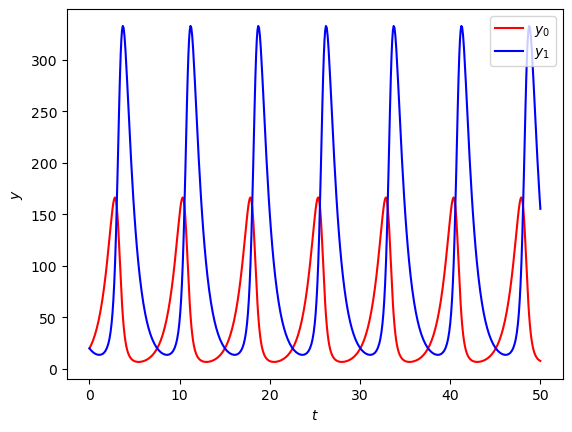

49.9 ms ± 83.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
# Test python
# 38.4ms
time_domain, y_results, success, message = nbrk_ode_py(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)


%timeit nbrk_ode_py(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

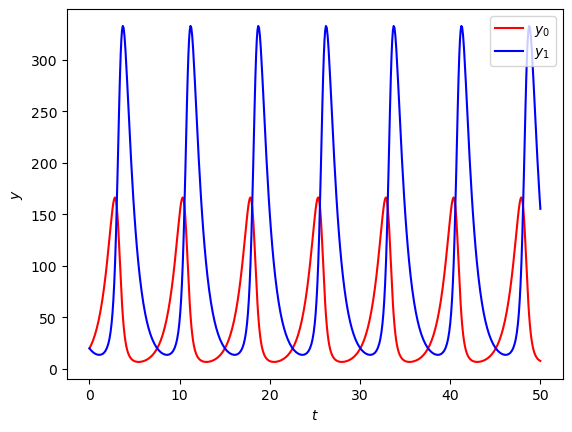

399 µs ± 980 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
# Test Numba - RK45
# 2.05ms
# >>0.2.3 1.93ms
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

C:\ProgramData\Anaconda3\envs\cyrk39v4\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


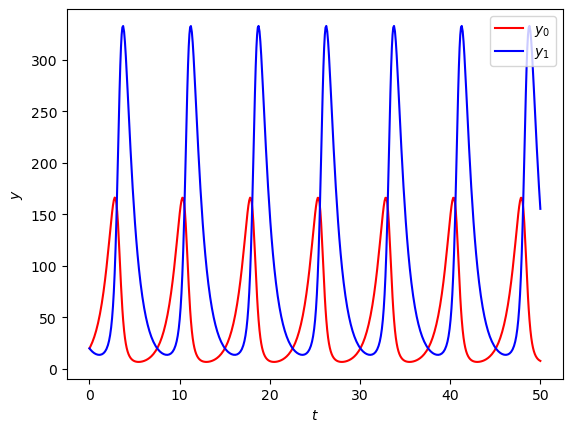

598 µs ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [53]:
# Test Numba - tester - RK45
# 2.05ms
# >>0.2.3 2.06ms
# >>0.3.0 0.946ms, 0.804ms, 0.629ms, 0.620ms, 615 us, 612us, 598us, 405us
# >>0.4.0 583us, 584us, 616us, 598us
time_domain, y_results, success, message = nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

C:\ProgramData\Anaconda3\envs\cyrk39v4\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


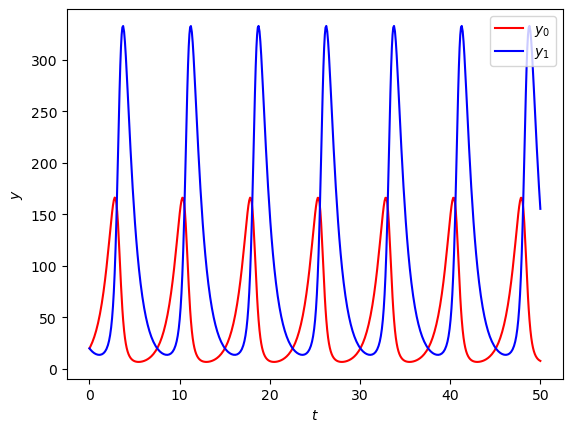

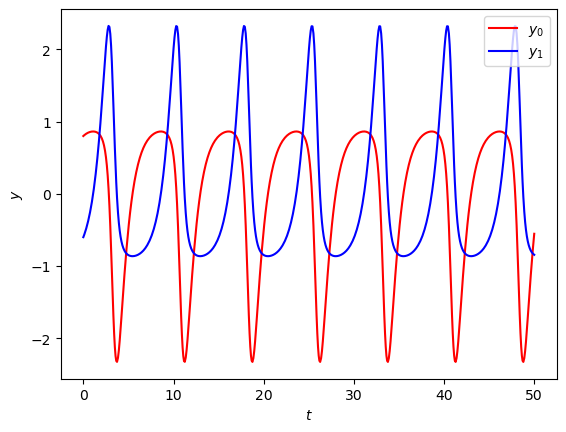

945 µs ± 8.02 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [59]:
# Test Numba - tester - extra output (interpolate Not Needed)
## v0.4.0 - 963us, 948us, 964us, 945us
time_domain, all_results, success, message = nbrk_ode_tester(y_diff_extra, time_span, initial_conds,
                                                             rtol=rtol, atol=atol,
                                                             capture_extra=True)
y_results = all_results[:2, :]
diff_plot(time_domain, y_results)
extra_results = all_results[2:, :]
diff_plot(time_domain, extra_results)

%timeit nbrk_ode_tester(y_diff_extra, time_span, initial_conds, rtol=rtol, atol=atol, capture_extra=True)

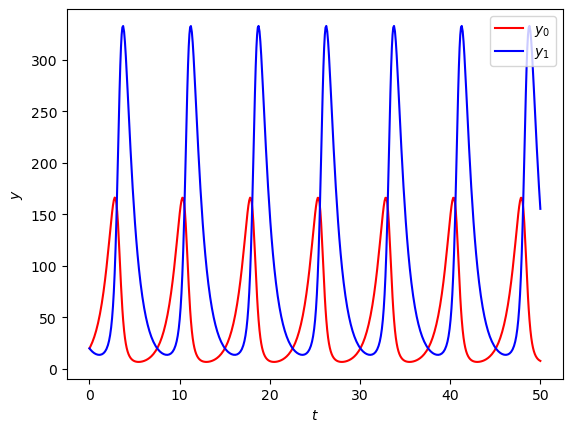

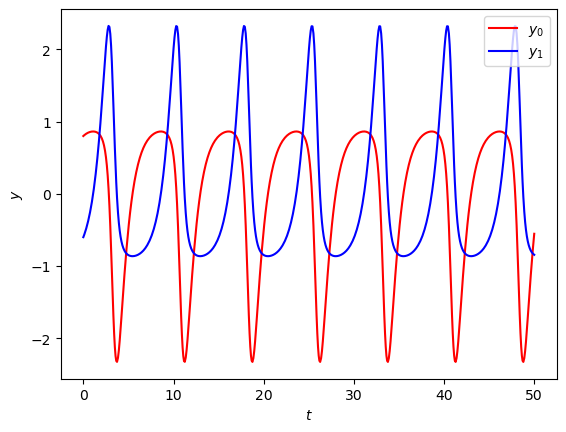

1.14 ms ± 5.43 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [64]:
# Test Numba - tester - extra (Lots) output (interpolate Not Needed)
## v0.4.0 - 1.14ms
time_domain, all_results, success, message = nbrk_ode_tester(y_diff_extra_extra, time_span, initial_conds,
                                                             rtol=rtol, atol=atol,
                                                             capture_extra=True)
y_results = all_results[:2, :]
diff_plot(time_domain, y_results)
extra_results = all_results[2:, :]
diff_plot(time_domain, extra_results)

%timeit nbrk_ode_tester(y_diff_extra_extra, time_span, initial_conds, rtol=rtol, atol=atol, capture_extra=True)

Integration finished with no issue.


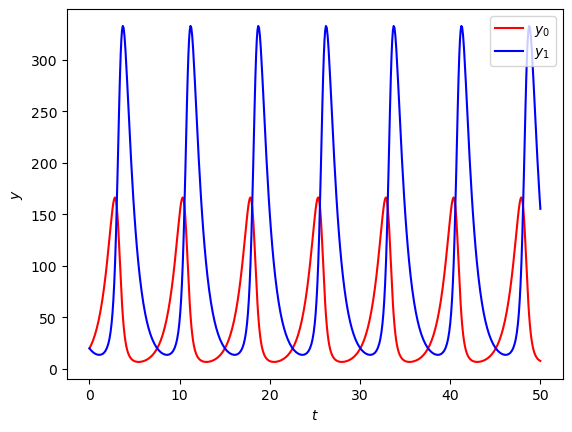

2.05 ms ± 29.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
# Test Cython - RK45

# 60ms
# 53.5ms
# 56.7ms, 56.1ms
# 56.8ms
# 47.8ms
# 36ms
# 35ms
# 26.9ms
# 26.6ms
# started adding mem views and it sucks now. 55ms
# 21.5ms
# 17.6ms
# 17ms
# 16.8ms
# 14.6ms
# 9.16ms
# 8.62ms
# 6.14ms
# 4.41ms
# 4.33ms
# 4.25ms
# 4.1ms
# 4.15ms
# 4.08ms
# 4.07ms
# 3.94ms
# 3.49ms
# 3.43ms
# 3.33ms
# 3.25ms
# 2.96ms
# 2.92ms
# 2.78ms
# 2.55ms
# 2.33ms
# 2.82ms  (added teval functionality)
# 2.61ms
# 2.73ms  (added DOP)
# 2.63ms
# 2.45ms
# 2.32ms
# >>0.2.3 2.42ms
# 2.4ms
# 2.31ms
# >>0.3.0 2.1ms
# >>0.4.0 2.02ms

time_domain, y_results, success, message = cyrk_ode(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, y_results)

%timeit cyrk_ode(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=1)

Integration finished with no issue.


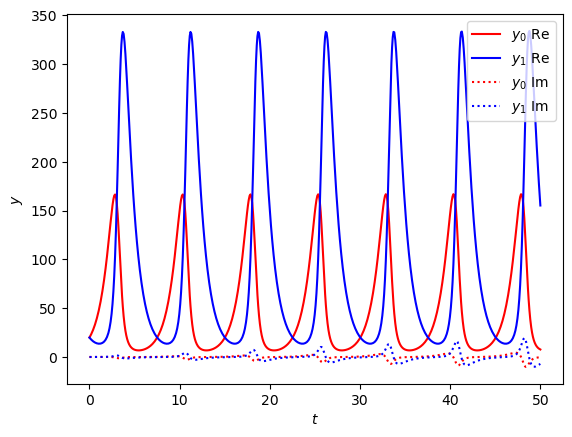

2.18 ms ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
# Cython with type checking (COMPLEX)
# 2.18ms

time_domain, y_results, success, message = cyrk_ode_notype(y_diff2, time_span, initial_conds_complex,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, y_results, is_complex=True)

%timeit cyrk_ode_notype(y_diff2, time_span, initial_conds_complex, rtol=rtol, atol=atol, rk_method=1)

Integration finished with no issue.


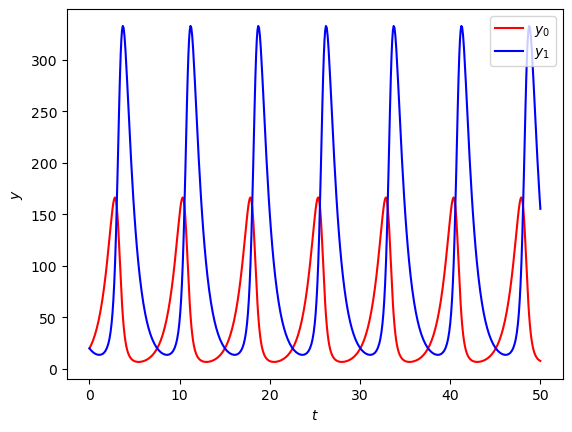

1.78 ms ± 6.72 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
# Cython with type checking (FLOAT)
# 1.73ms, 1.78ms

time_domain, y_results, success, message = cyrk_ode_notype(y_diff2, time_span, initial_conds_float,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, y_results)

%timeit cyrk_ode_notype(y_diff2, time_span, initial_conds_float, rtol=rtol, atol=atol, rk_method=1)

Integration finished with no issue.


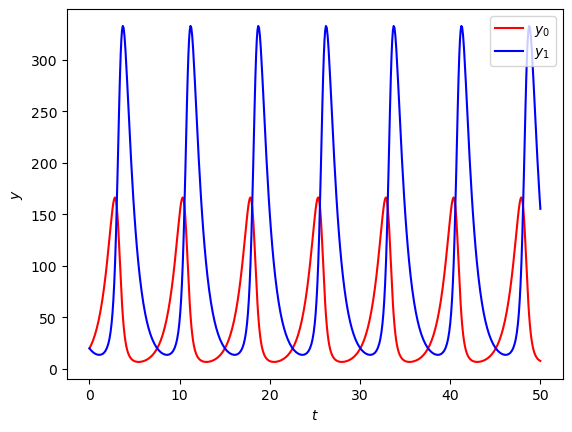

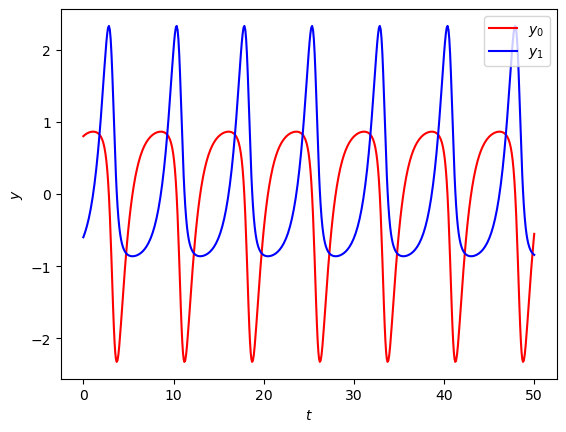

2.12 ms ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [83]:
# Test Cython - RK45 - Extra outputs
# v0.4.0 2.31ms, 2.28ms, 2.12ms

time_domain, y_results, success, message = cyrk_ode(y_diff2_extra, time_span, initial_conds,
                                                    rtol=rtol, atol=atol, rk_method=1,
                                                    capture_extra=True, num_extra=2)
print(message)
diff_plot(time_domain, y_results[:2, :])
diff_plot(time_domain, y_results[2:, :])

%timeit cyrk_ode(y_diff2_extra, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=1, capture_extra=True, num_extra=2)


In [79]:
y_results.shape

(2, 360)

In [ ]:
# Cython with complex diffeq

time_domain, y_results, success, message = cyrk_ode(y_diff3, time_span, initial_conds_complex,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, np.real(y_results))
diff_plot(time_domain, np.imag(y_results))

%timeit cyrk_ode(y_diff3, time_span, initial_conds_complex, rtol=rtol, atol=atol, rk_method=1)

In [ ]:
# Numba with complex diffeq

time_domain, y_results, success, message = nbrk_ode_tester(y_diff4, time_span, initial_conds_complex,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, np.real(y_results))
diff_plot(time_domain, np.imag(y_results))

%timeit cyrk_ode(y_diff3, time_span, initial_conds_complex, rtol=rtol, atol=atol, rk_method=1)

### Check DOP

In [ ]:
# Test Numba - DOP
# 1.78ms
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)

In [ ]:
# Test Cython - DOP
# 4ms
# 2.92ms
# 2.8ms
# 2.65ms
# 2.51ms


time_domain, y_results, success, message = cyrk_ode(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, rk_method=2)
diff_plot(time_domain, y_results)

%timeit cyrk_ode(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, rk_method=2)

### Check t_eval

In [55]:
teval = np.linspace(0., time_span[1], 50)

In [ ]:
# Test Numba - t_eval
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)

In [ ]:
# Test Numba tester - t_eval
# 449us
time_domain, y_results, success, message = nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)
diff_plot(time_domain, y_results)

print('With teval')
%timeit nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)
print('Without teval')
%timeit nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol)

C:\ProgramData\Anaconda3\envs\cyrk39v4\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


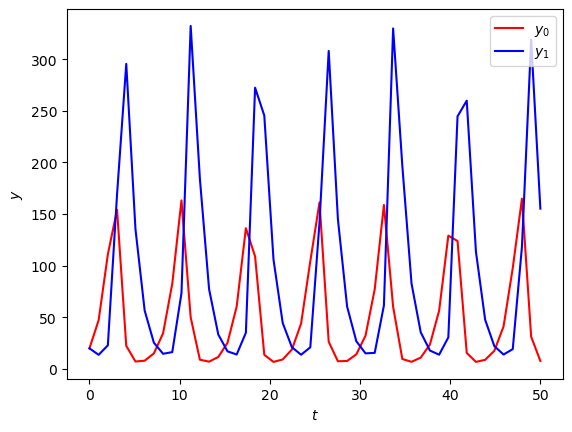

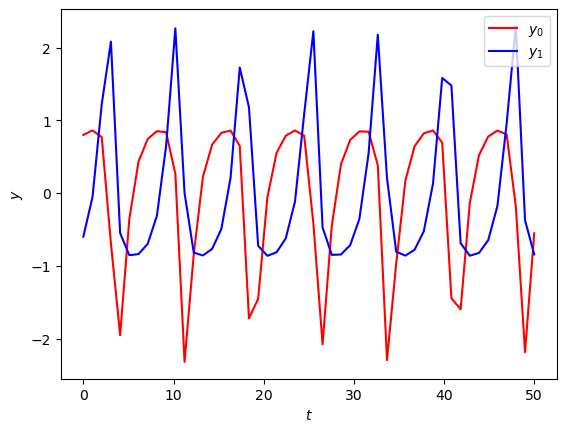

With teval (extra with Interpolation)
457 µs ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
Without teval (extra with Interpolation)
654 µs ± 117 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


C:\ProgramData\Anaconda3\envs\cyrk39v4\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


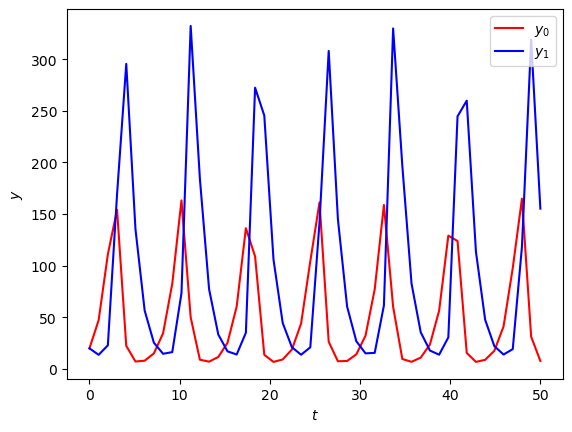

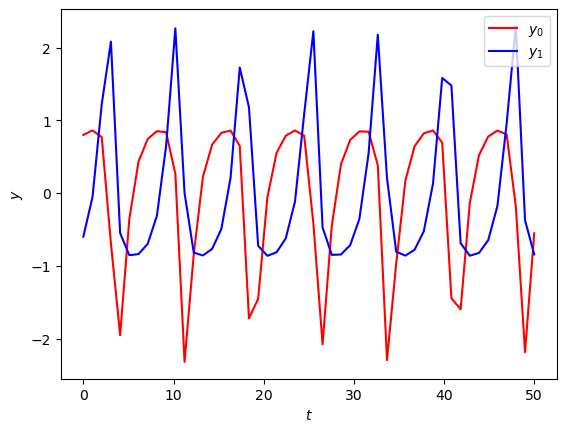

With teval (extra without Interpolation)
408 µs ± 4.58 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Without teval (extra without Interpolation)
595 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [60]:
# Test Numba tester - t_eval - extra output (Interpolation)
# >>0.4.0:: 437us, 457us
time_domain, y_results, success, message = nbrk_ode_tester(y_diff_extra, time_span, initial_conds,
                                                             rtol=rtol, atol=atol, t_eval=teval,
                                                             capture_extra=True, interpolate_extra=True)
diff_plot(time_domain, y_results[:2, :])
diff_plot(time_domain, y_results[2:, :])

print('With teval (extra with Interpolation)')
%timeit nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval, capture_extra=True, interpolate_extra=True)
print('Without teval (extra with Interpolation)')
%timeit nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, capture_extra=True, interpolate_extra=True)

# Test Numba tester - t_eval - extra output (No Interpolation)
# >>0.4.0:: 419us, 408us
time_domain, y_results, success, message = nbrk_ode_tester(y_diff_extra, time_span, initial_conds,
                                                             rtol=rtol, atol=atol, t_eval=teval,
                                                             capture_extra=True, interpolate_extra=False)
diff_plot(time_domain, y_results[:2, :])
diff_plot(time_domain, y_results[2:, :])

print('With teval (extra without Interpolation)')
%timeit nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval, capture_extra=True, interpolate_extra=False)
print('Without teval (extra without Interpolation)')
%timeit nbrk_ode_tester(y_diff, time_span, initial_conds, rtol=rtol, atol=atol, capture_extra=True, interpolate_extra=False)

Integration finished with no issue.


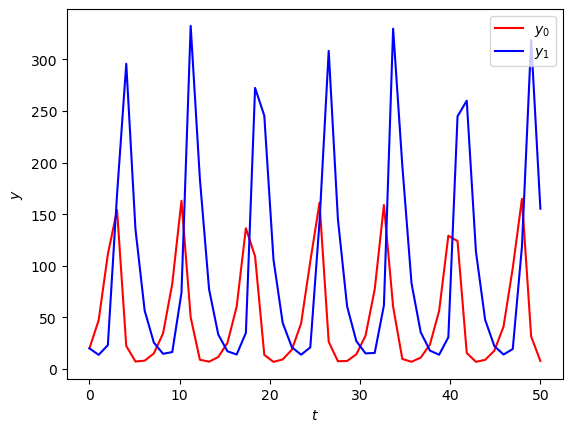

2.13 ms ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [85]:
# Test Cython - t_eval
# 2.74ms
# >>v0.4.0 2.1ms, 2.13ms
time_domain, y_results, success, message = cyrk_ode(y_diff2, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval)
print(message)
diff_plot(time_domain, y_results)

%timeit cyrk_ode(y_diff2, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval)

Integration finished with no issue.


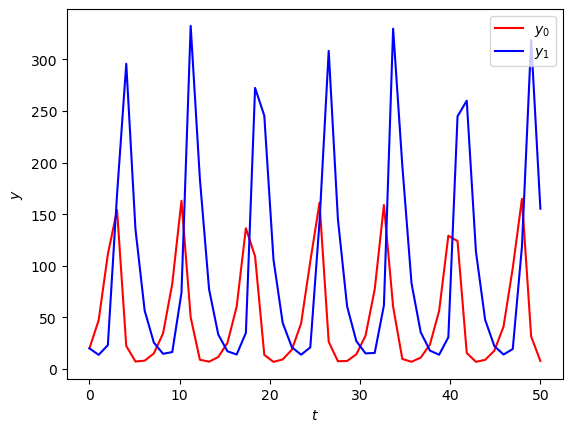

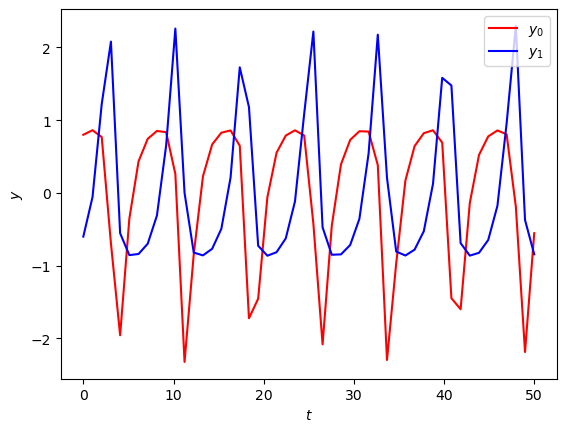

2.15 ms ± 5.39 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [88]:
# Test Cython - t_eval - extra output (Interpolate extra off)
# 2.74ms
# >> v0.4.0 2.19ms, 2.15ms
time_domain, y_results, success, message = cyrk_ode(y_diff2_extra, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval,
                                                    capture_extra=True, num_extra=2, interpolate_extra=False)
print(message)
diff_plot(time_domain, y_results[:2, :])
diff_plot(time_domain, y_results[2:, :])

%timeit cyrk_ode(y_diff2_extra, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval, capture_extra=True, num_extra=2, interpolate_extra=False)

Integration finished with no issue.


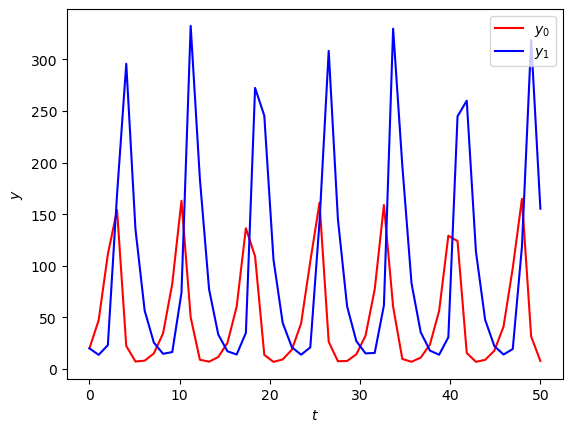

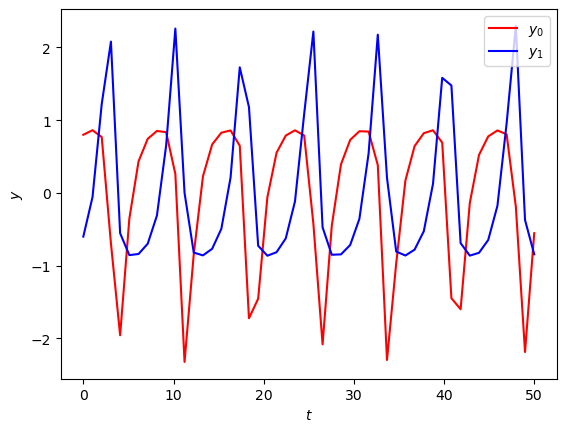

2.36 ms ± 14.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
# Test Cython - t_eval - extra output (Interpolate extra on)
# 2.74ms
# >> v0.4.0 2.35ms, 2.36ms
time_domain, y_results, success, message = cyrk_ode(y_diff2_extra, time_span, initial_conds,
                                                           rtol=rtol, atol=atol, t_eval=teval,
                                                    capture_extra=True, num_extra=2, interpolate_extra=True)
print(message)
diff_plot(time_domain, y_results[:2, :])
diff_plot(time_domain, y_results[2:, :])

%timeit cyrk_ode(y_diff2_extra, time_span, initial_conds, rtol=rtol, atol=atol, t_eval=teval, capture_extra=True, num_extra=2, interpolate_extra=True)

### Check larger t domain

In [ ]:
time_span_2 = (0., 5000.)

In [ ]:
# Test python
# 5.3 s
time_domain, y_results, success, message = nbrk_ode_py(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode_py(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)

In [ ]:
# Test Numba - RK45
# 1800 ms
# 2350 ms
# >>0.2.3 1.83 s
# >>0.3.0 44.3 ms
time_domain, y_results, success, message = nbrk_ode(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)

In [ ]:
# Test Numba - tester - RK45
# 1800 ms
# 2350 ms
# >>0.2.3 1.83 s
# >>0.3.0 1.56 s, 1.46s, 1.41s, 1.42s, 45.6ms,
# >>0.3.0a2 43.3
time_domain, y_results, success, message = nbrk_ode_tester(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)
diff_plot(time_domain, y_results)

%timeit nbrk_ode_tester(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)

In [ ]:
# Test Cython - RK45
# 238 ms
# 229 ms
# >>0.2.3 0.231 s

time_domain, y_results, success, message = cyrk_ode(y_diff2, time_span_2, initial_conds,
                                                           rtol=rtol, atol=atol, rk_method=1)
print(message)
diff_plot(time_domain, y_results)

%timeit cyrk_ode(y_diff2, time_span_2, initial_conds, rtol=rtol, atol=atol, rk_method=1)

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f nbrk_ode_tester.py_func nbrk_ode_tester.py_func(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)

In [ ]:
%load_ext memory_profiler

In [ ]:
from CyRK.nb.nbrk import nbrk_ode
%mprun -f nbrk_ode nbrk_ode.py_func(y_diff, time_span_2, initial_conds, rtol=rtol, atol=atol)